In [1]:
import logging, os, pickle
import requests, glob
from datetime import datetime
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
import time
from datetime import date
import urllib.request
from selenium.webdriver import Chrome
import json, re, sys, h5py
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
import datetime as dt
import pymysql
import matplotlib.pyplot as plt
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from pykrx import stock
import warnings
warnings.filterwarnings(action='ignore')
import shutil
from matplotlib.pyplot import cm
import numpy as np
import scipy.stats as stats
from scipy import stats
import pyautogui
from statsmodels.tsa.stattools import coint, adfuller

In [2]:
from Loader_v2 import Loader
ldr = Loader()
conn = pymysql.connect(host='localhost',user='root',
                                   password='tlqkfdk2',db='INVESTAR',charset='utf8')

---

## Daily Update for KOSPI, Stock_Price

In [21]:
def GetDailyPrice_lv1(today='2021-02-25'):
    conn = pymysql.connect(host='localhost',user='root',
                                   password='tlqkfdk2',db='INVESTAR',charset='utf8')
    all_codes = list(pd.read_sql("select * from company_info",conn).code.values)
    all_codes = all_codes + ['005935','005385','066575']
    print("The number of codes : {}".format(len(all_codes)))
    errs = []
    year = today[:4]
    tmp_pr = pd.read_hdf("FullCache/Price/price_{}.h5".format(str(year)))
    print('original size : {}'.format(tmp_pr.shape))
    with open("TradingDates.pickle","rb") as fr:
        trading_dates = pickle.load(fr)
    start_date = pd.to_datetime(str(max(tmp_pr.DATE))).strftime("%Y-%m-%d")
    start = start_date.replace('-','')
    end = today.replace('-','')
    total = pd.DataFrame()
    assert start != end
    print("Updating prices during : {} ~ {}".format(start_date, today))
    for cd in all_codes :
        try :
            tmp = stock.get_market_ohlcv_by_date(start, end, cd, adjusted=True)
            if len(tmp) == 0 :
                errs.append(start+'|'+end+'|'+cd)
            else :
                tmp.rename(columns={'시가':'OPEN','고가':'high','저가':'low','종가':'adjprice','거래량':'volume'},inplace=True)
                tmp.index.names = ['DATE']
                tmp.reset_index(inplace=True)
                tmp['CODE'] = '{:06d}'.format(int(cd))
                tmp['CODE'] = tmp['CODE'].astype(str)
                total = pd.concat([total, tmp])
        except Exception as e:
            print(e)
            errs.append(start+'|'+end+'|'+cd)
    total.reset_index(drop=True, inplace=True)
    dates = [pd.to_datetime(str(e)).strftime("%Y-%m-%d") for e in list(total.DATE.values)]
    total['DATE'] = dates
    duplicates = list(total[total.DATE==start_date].index)
    if len(duplicates) != 0 :
        total.drop(index=duplicates, axis=0, inplace=True)
    
    new_df = total.copy()
    new_df.to_hdf("./FullCache/Price/price_update_{}.h5".format(end),key='price')
    total = pd.concat([tmp_pr, total])
    dates = [pd.to_datetime(str(e)).strftime("%Y-%m-%d") for e in list(total.DATE.values)]
    total['DATE'] = dates
    total.to_hdf("./FullCache/Price/price_{}.h5".format(str(year)),key='price')
    print('merged size : {}'.format(total.shape))
    print("Daily lv1 Price update is finished -> {} ~ {}".format(min(dates), max(dates)))
    return True #new_df, total, errs

In [4]:
def GetDailyPrice_lv2(today='2021-02-25'):
    year = today[:4]
    original_pr = pd.read_hdf("./FullCache/Price/lv2_price_{}.h5".format(str(year)))
    total_pr = pd.read_hdf("./FullCache/Price/lv2_price_total.h5")
    if os.path.isfile(glob.glob("./FullCache/Price/price_update_*.h5")[0]):
        pass
    else :
        raise ValueError("lv1 update file does not exist!!!")
    tmp_pr = pd.read_hdf(glob.glob("./FullCache/Price/price_update_*.h5")[0])
    print('original size : {}'.format(original_pr.shape))
    print('total size : {}'.format(total_pr.shape))
    
    tmp_lv2 = lv2(tmp_pr)
    assert len(tmp_lv2)!=0
    print('update size : {}'.format(tmp_lv2.shape))
    total_pr = pd.concat([total_pr,tmp_lv2]).sort_index()
    original_pr = pd.concat([original_pr,tmp_lv2]).sort_index()
    
    total_pr.to_hdf("./FullCache/Price/lv2_price_total.h5",key='price')
    original_pr.to_hdf("./FullCache/Price/lv2_price_{}.h5".format(str(year)),key='price')
    print('merged size : {}'.format(original_pr.shape))
    print("Daily lv2 Price update is finished -> {} ~ {}".format(min(tmp_lv2.index), max(tmp_lv2.index)))
    
    os.remove(glob.glob("./FullCache/Price/price_update_*.h5")[0])
    
    return True

In [5]:
def lv2(df):
    codes = list(set(df.CODE.values))
    total = pd.DataFrame()
    for cd in codes :
        tmp = df[lambda x : x['CODE']==cd]
        tmp.index = list(tmp.DATE.values)
        tmp = tmp[['adjprice']]
        tmp.sort_index(inplace=True)
        tmp.columns = [cd]
        total = pd.concat([total,tmp],axis=1)
    return total

In [39]:
def GetDailyKOSPI_lv1(today='2021-02-25'):
    
    end = today.replace('-','')
    
    url = 'https://m.stock.naver.com/api/json/sise/dailySiseIndexListJson.nhn?code=KOSPI&pageSize=100'
    res = requests.get(url,headers={"User-Agent":"Chrome 88 on Windows 10"})
    rst = res.text
    tmp = res.json()
    kospi = pd.DataFrame(tmp['result']['siseList'])
    kospi['dt'] = kospi['dt'].astype(str)
    
    original = pd.read_hdf("./FullCache/KOSPI.h5")
    print("original size : {}".format(original.shape))
    
    last_date = max(original.dt.values)
    #new_kospi = kospi[lambda x : x['dt'] > last_date]
    new_kospi = kospi[(kospi['dt']>last_date)&(kospi['dt']<=end)]
    print("update size : {}".format(new_kospi.shape))
    
    original = pd.concat([new_kospi,original]).reset_index(drop=True)
    print("merged size : {}".format(original.shape))
    
    original.to_hdf("./FullCache/KOSPI.h5",key='kospi')
    new_kospi.to_hdf("./FullCache/KOSPI_update_{}.h5".format(end),key='kospi')
    
    return True

In [36]:
def GetDailyKOSPI_lv2(today='2021-02-25'):
    
    if os.path.isfile(glob.glob("./FullCache/KOSPI_update_*.h5")[0]):
        pass
    else :
        raise ValueError("lv1 update file does not exist!!!")
        
    tmp = pd.read_hdf(glob.glob("./FullCache/KOSPI_update_*.h5")[0])
    total = pd.read_hdf("./FullCache/KOSPI_lv2.h5")
    print('total size : {}'.format(total.shape))
    
    dates = [dt[:4]+'-'+dt[4:6]+'-'+dt[6:8] for dt in list(tmp.dt.values)]
    tmp.index = dates
    tmp = tmp[['ncv']].sort_index()
    tmp.columns = ['close']
    print("update size : {}".format(tmp.shape))
    assert len(tmp)!=0
    total = pd.concat([total,tmp]).sort_index()
    print("merged size : {}".format(total.shape))
    total.to_hdf("./FullCache/KOSPI_lv2.h5",key='kospi')
    print("Daily lv2 KOSPI update is finished -> {} ~ {}".format(min(tmp.index), max(tmp.index)))
    
    os.remove(glob.glob("./FullCache/KOSPI_update_*.h5")[0])
    return True

In [70]:
def GetMarcapCrawler(today='2021-02-25'):
    driver_path = "C:/Users/Bae Kyungmo/OneDrive/Desktop/WC_basic/chromedriver.exe"
    url = "http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201"
    browser = Chrome(driver_path)
    browser.maximize_window()
    browser.get(url)
    pyautogui.moveTo(262, 484, duration=1.0)
    pyautogui.click()
    pyautogui.moveTo(301, 521, duration=1.0)
    pyautogui.click()
    pyautogui.moveTo(323, 549, duration=1.0)
    pyautogui.click()
    pyautogui.moveTo(732, 419, duration=1.0)
    time.sleep(12)
    pyautogui.doubleClick()
    time.sleep(1)
    browser.find_elements_by_xpath('//*[@id="trdDd"]')[0].send_keys(today.replace('-',''))
    pyautogui.moveTo(1580, 377, duration=1.0)
    time.sleep(1)
    pyautogui.click()
    time.sleep(1)
    pyautogui.moveTo(1647, 473, duration=1.0)
    pyautogui.click()
    pyautogui.moveTo(1550, 608, duration=1.0)
    pyautogui.click()
    time.sleep(3)
    try :
        fp = glob.glob("C:/Users/Bae Kyungmo/Downloads/data*")[0]
    except :
        raise ValueError("Update file is not downloaded!!!")
    if os.path.isfile(fp):
        to_fp = "./FullCache/marcap/marcap-{}.csv".format(today)
        os.rename(fp, to_fp)
    return to_fp

In [71]:
def GetDailyMarcap(today='2021-02-25'):
    with open("TradingDates.pickle","rb") as fr:
        trading_dates = pickle.load(fr)
    if today not in trading_dates:
        print("The date is not a trading date.")
        return False
    year = today[:4]
    total = pd.read_csv("./FullCache/marcap/marcap-{}.csv".format(year))
    if len(total[lambda x : x['Date']==today])!=0:
        print("Already data exist at that date.")
        return False
    fp = GetMarcapCrawler(today=today)
    tmp = pd.read_csv(fp, encoding='cp949')
    assert len(tmp)!=0
    num_col = total.shape[1]
    print("original size : {}".format(total.shape))
    tmp = tmp.rename(columns={'종목코드':'Code','종목명':'Name','종가':'Close','대비':'Changes','등락률':'ChagesRatio','거래량':'Volume','거래대금':'Amount',
                   '시가':'Open','고가':'High','저가':'Low','시가총액':'Marcap','상장주식수':'Stocks','시장구분':'Market','소속부':'Dept'})
    tmp['Date'] = today
    print("update size : {}".format(tmp.shape))
    total = pd.concat([total,tmp]).sort_values(by=['Date']).reset_index(drop=True)
    print("merged size : {}".format(total.shape))
    total.to_csv("./FullCache/marcap/marcap-{}.csv".format(year),index=False)
    print("updating marcap is finished.")
    assert num_col == total.shape[1]
    os.remove(fp)
    return True

In [10]:
%%time
today = '2021-03-03'
GetDailyPrice_lv1(today)
GetDailyPrice_lv2(today)
GetDailyKOSPI_lv1(today)
GetDailyKOSPI_lv2(today)
GetDailyMarcap(today)

The number of codes : 2414
original size : (91566, 7)
Updating prices during : 2021-02-26 ~ 2021-03-03
merged size : (96386, 7)
Daily lv1 Price update is finished -> 2021-01-04 ~ 2021-03-03
original size : (38, 2414)
total size : (2752, 2414)
update size : (2, 2410)
merged size : (40, 2414)
Daily lv2 Price update is finished -> 2021-03-02 ~ 2021-03-03
original size : (8110, 8)
update size : (3, 8)
merged size : (8113, 8)
total size : (8110, 1)
update size : (3, 1)
merged size : (8113, 1)
Daily lv2 KOSPI update is finished -> 2021-03-02 ~ 2021-03-04
Wall time: 2min 8s


True

##### Funda

In [28]:
fundas.shape

(364318, 5)

In [29]:
%%time
for idx, row in fundas.iterrows():
    if row.itm in ['EPS','BPS']:
        fundas.loc[idx,'value'] = fundas.loc[idx,'value'] * 100000000
    elif row.itm in ['PBR','PER','PCR','POR','PSR']:
        fundas.loc[idx,'value'] = fundas.loc[idx,'value'] / 100000000

Wall time: 4min 56s


In [32]:
fundas = fundas.reset_index(drop=True)

In [33]:
fundas.to_hdf("./FullCache/FUNDA_total.h5",key='funda')

---

---

### Sector Thema Codes

In [1]:
def SectorNThemaCodeGen(url):
    code_raw = pd.read_html(url,encoding='cp949')[2]['종목명'].dropna(axis=0).values
    code_raw = [e.replace(' *','') for e in code_raw]
    code = []
    for e in code_raw:
        try :
            code.append(ldr.FindCodeByName(e))
        except :
            pass
    return code

In [ ]:
total_dict = {}
total_dict['제약'] = SectorNThemaCodeGen('https://finance.naver.com/sise/sise_group_detail.nhn?type=upjong&no=35')
total_dict['반도체'] = SectorNThemaCodeGen('https://finance.naver.com/sise/sise_group_detail.nhn?type=upjong&no=202')
total_dict['디스플레이'] = SectorNThemaCodeGen('https://finance.naver.com/sise/sise_group_detail.nhn?type=upjong&no=199')
total_dict['IT'] = SectorNThemaCodeGen('https://finance.naver.com/sise/sise_group_detail.nhn?type=upjong&no=154')
total_dict['코로나'] = SectorNThemaCodeGen('https://finance.naver.com/sise/sise_group_detail.nhn?type=theme&no=436')
total_dict['유전자'] = SectorNThemaCodeGen('https://finance.naver.com/sise/sise_group_detail.nhn?type=theme&no=376')
total_dict['2차전지'] = SectorNThemaCodeGen('https://finance.naver.com/sise/sise_group_detail.nhn?type=theme&no=64')
total_dict['클라우드'] = SectorNThemaCodeGen('https://finance.naver.com/sise/sise_group_detail.nhn?type=theme&no=276')
total_dict['쿠팡'] = SectorNThemaCodeGen('https://finance.naver.com/sise/sise_group_detail.nhn?type=theme&no=474')
total_dict['증강현실'] = SectorNThemaCodeGen('https://finance.naver.com/sise/sise_group_detail.nhn?type=theme&no=289')
total_dict['자율주행차'] = SectorNThemaCodeGen('https://finance.naver.com/sise/sise_group_detail.nhn?type=theme&no=362')
total_dict['4차산업'] = SectorNThemaCodeGen('https://finance.naver.com/sise/sise_group_detail.nhn?type=theme&no=375')
total_dict['음성인식'] = SectorNThemaCodeGen('https://finance.naver.com/sise/sise_group_detail.nhn?type=theme&no=302')
total_dict['인터넷은행'] = SectorNThemaCodeGen('https://finance.naver.com/sise/sise_group_detail.nhn?type=theme&no=343')
total_dict['게임'] = list(set(set(SectorNThemaCodeGen('https://finance.naver.com/sise/sise_group_detail.nhn?type=theme&no=265')).union(set(SectorNThemaCodeGen('https://finance.naver.com/sise/sise_group_detail.nhn?type=theme&no=42')))))
total_dict['전자결제'] = SectorNThemaCodeGen('https://finance.naver.com/sise/sise_group_detail.nhn?type=theme&no=272')
total_dict['5G'] = SectorNThemaCodeGen('https://finance.naver.com/sise/sise_group_detail.nhn?type=theme&no=373')

### Get Price info from 2010 ~ 2020

In [ ]:
stock.get_market_ohlcv_by_date('20100101', '20201231', '352820', adjusted=True)

In [3]:
comp = pd.read_sql("select * from company_info",conn)

In [34]:
comp[lambda x : x['company']=='빅히트']

,code,company,last_update,sector,market
2366,352820,빅히트,2021-01-06,오디오물 출판 및 원판 녹음업,KOSPI


In [4]:
all_codes = list(comp.code.values)

In [10]:
with open("TradingDates.pickle","rb") as fr:
    trading_dates = pickle.load(fr)

In [14]:
datetime.now().strftime("%Y-%m-%d")

'2021-02-22'

In [15]:
'2021-02-22'.replace('-','')

'20210222'

In [ ]:
def GetDailyPrice(all_codes):
    all_codes = all_codes + ['005935','005385','066575']
    print(len(all_codes))
    errs = []
    tmp_pr = pd.read_hdf("FullCache/Price/price_{}.h5".format(str(year)))
    with open("TradingDates.pickle","rb") as fr:
        trading_dates = pickle.load(fr)
    last_update = tmp_pr.index[-1]
    idx = trading_dates.index(last_update)
    start_date = trading_dates[idx+1]
    today = datetime.now().strftime("%Y-%m-%d")
    year=[today[:4]]
    for y in year :
        start = start_date.replace('-','')
        end = today.replace('-','')
        total = pd.DataFrame()
        for cd in all_codes :
            try :
                tmp = stock.get_market_ohlcv_by_date(start, end, cd, adjusted=True)
                if len(tmp) == 0 :
                    continue
                else :
                    tmp.rename(columns={'시가':'OPEN','고가':'high','저가':'low','종가':'adjprice','거래량':'volume'},inplace=True)
                    tmp.index.names = ['DATE']
                    tmp.reset_index(inplace=True)
                    tmp['CODE'] = '{:06d}'.format(int(cd))
                    tmp['CODE'] = tmp['CODE'].astype(str)
                    total = pd.concat([total, tmp])
            except Exception as e:
                print(e)
                errs.append(str(y)+'-'+cd)
        #total.to_csv("./FullCache/Price/price_{}.csv".format(str(y)),index=False)
        total = pd.concat([tmp_pr,total])
        total.to_hdf("./FullCache/Price/price_{}.h5".format(str(y)),key='price')
        print("{} is finished - size : {}".format(y, total.shape))
    return errs

In [22]:
def lv2(df_ls):
    real_total = pd.DataFrame()
    for df in df_ls :
        dates = sorted(list(set(df.DATE.values)))
        codes = list(set(df.CODE.values))
        total = pd.DataFrame()
        for cd in codes :
            tmp = df[lambda x : x['CODE']==cd].sort_values(by=['DATE'])[['DATE','adjprice']]
            tmp.index = [dt.strftime("%Y-%m-%d") for dt in tmp.DATE]
            tmp.drop(['DATE'],axis=1,inplace=True)
            tmp.columns = [cd]
            total = pd.concat([total,tmp],axis=1)
        real_total = pd.concat([real_total,total],axis=0)
    return real_total


def lv2_cache():
    #real_total = pd.DataFrame()
    years = [i for i in range(2010,2022)]
    for y in years :
        print(y)
        df = pd.read_hdf("FullCache/Price/price_{}.h5".format(str(y)))
        dates = sorted(list(set(df.DATE.values)))
        codes = list(set(df.CODE.values))
        total = pd.DataFrame()
        for cd in codes :
            tmp = df[lambda x : x['CODE']==cd].sort_values(by=['DATE'])[['DATE','adjprice']]
            tmp.index = [dt.strftime("%Y-%m-%d") for dt in tmp.DATE]
            tmp.drop(['DATE'],axis=1,inplace=True)
            tmp.columns = [cd]
            total = pd.concat([total,tmp],axis=1)
        total.to_hdf("FullCache/Price/lv2_price_{}.h5".format(str(y)),key='price')
        #real_total = pd.concat([real_total,total],axis=0)
    return True

In [7]:
def GetAllPriceUpUpdate(all_codes):
    errs = []
    year = [2021]
    for y in year :
        start = str(y)+'0101'
        end = str(y)+'0217'
        total = pd.DataFrame()
        for cd in all_codes :
            try :
                tmp = stock.get_market_ohlcv_by_date(start, end, cd, adjusted=True)
                if len(tmp) == 0 :
                    continue
                else :
                    tmp.rename(columns={'시가':'OPEN','고가':'high','저가':'low','종가':'adjprice','거래량':'volume'},inplace=True)
                    tmp.index.names = ['DATE']
                    tmp.reset_index(inplace=True)
                    tmp['CODE'] = '{:06d}'.format(int(cd))
                    tmp['CODE'] = tmp['CODE'].astype(str)
                    total = pd.concat([total, tmp])
            except Exception as e:
                print(e)
                errs.append(str(y)+'-'+cd)
        #total.to_csv("./FullCache/Price/price_{}.csv".format(str(y)),index=False)
        total.to_hdf("./FullCache/Price/price_{}.h5".format(str(y)),key='price')
        print("{} is finished - size : {}".format(y, total.shape))
    return errs

In [8]:
%%time
errs = GetAllPriceUpUpdate(all_codes)

2021 is finished - size : (74696, 7)
Wall time: 1min 4s


In [6]:
def GetAllPriceUpUpdate(all_codes):
    all_codes = all_codes + ['005935','005385','066575']
    print(len(all_codes))
    errs = []
    year = [2021]
    for y in year :
        start = str(y)+'0218'
        end = str(y)+'0222'
        total = pd.DataFrame()
        for cd in all_codes :
            try :
                tmp = stock.get_market_ohlcv_by_date(start, end, cd, adjusted=True)
                if len(tmp) == 0 :
                    continue
                else :
                    tmp.rename(columns={'시가':'OPEN','고가':'high','저가':'low','종가':'adjprice','거래량':'volume'},inplace=True)
                    tmp.index.names = ['DATE']
                    tmp.reset_index(inplace=True)
                    tmp['CODE'] = '{:06d}'.format(int(cd))
                    tmp['CODE'] = tmp['CODE'].astype(str)
                    total = pd.concat([total, tmp])
            except Exception as e:
                print(e)
                errs.append(str(y)+'-'+cd)
        #total.to_csv("./FullCache/Price/price_{}.csv".format(str(y)),index=False)
        total.to_hdf("./FullCache/Price/new_price_{}.h5".format(str(y)),key='price')
        print("{} is finished - size : {}".format(y, total.shape))
    return errs

In [ ]:
'005935','005385','066575'

In [5]:
len(all_codes)

2411

In [7]:
%%time
errs = GetAllPriceUpUpdate(all_codes)

2414
2021 is finished - size : (7230, 7)
Wall time: 3min 8s


In [16]:
qwe = pd.read_hdf("FullCache/Price/new_price_2021.h5")

In [19]:
set(qwe.sort_values(by=['DATE']).DATE.values)

{numpy.datetime64('2021-02-18T00:00:00.000000000'),
 numpy.datetime64('2021-02-19T00:00:00.000000000'),
 numpy.datetime64('2021-02-22T00:00:00.000000000')}

In [40]:
qwe2 = lv2([rr])

In [24]:
'005935' in qwe2.columns

True

In [27]:
len(set(qwe.CODE.values))

2410

In [28]:
tmp = pd.read_hdf("FullCache/Price/price_2021.h5")

In [30]:
len(set(tmp.CODE))

2411

In [37]:
rr = pd.concat([tmp,qwe])

In [39]:
rr.to_hdf("FullCache/Price/price_2021.h5",key='price')

In [43]:
qwe2.isnull().sum()[lambda x : x>0]

005385    31
036260     6
066575    31
005935    31
241510    18
291210    25
278380     8
dtype: int64

In [44]:
qwe2.to_hdf("FullCache/Price/lv2_price_2021.h5",key='price')

In [159]:
def GetAllPrice(all_codes):
    errs = []
    year = [2010+i for i in range(11)]
    for y in year :
        start = str(y)+'0101'
        end = str(y)+'1231'
        total = pd.DataFrame()
        for cd in all_codes :
            try :
                tmp = stock.get_market_ohlcv_by_date(start, end, cd, adjusted=True)
                if len(tmp) == 0 :
                    continue
                else :
                    tmp.rename(columns={'시가':'OPEN','고가':'high','저가':'low','종가':'adjprice','거래량':'volume'},inplace=True)
                    tmp.index.names = ['DATE']
                    tmp.reset_index(inplace=True)
                    tmp['CODE'] = '{:06d}'.format(int(cd))
                    tmp['CODE'] = tmp['CODE'].astype(str)
                    total = pd.concat([total, tmp])
            except Exception as e:
                print(e)
                errs.append(str(y)+'-'+cd)
        #total.to_csv("./FullCache/Price/price_{}.csv".format(str(y)),index=False)
        total.to_hdf("./FullCache/Price/price_{}.h5".format(str(y)),key='price')
        print("{} is finished - size : {}".format(y, total.shape))
    return errs

In [160]:
%%time
errs = GetAllPrice(all_codes)

2010 is finished - size : (352596, 7)
2011 is finished - size : (369036, 7)
2012 is finished - size : (382335, 7)
2013 is finished - size : (391564, 7)
2014 is finished - size : (405608, 7)
2015 is finished - size : (438191, 7)
2016 is finished - size : (467050, 7)
2017 is finished - size : (488051, 7)
2018 is finished - size : (514382, 7)
2019 is finished - size : (548143, 7)
2020 is finished - size : (581624, 7)
Wall time: 35min 36s


In [162]:
hey = pd.read_hdf("./FullCache/Price/price_2020.h5")

<AxesSubplot:>

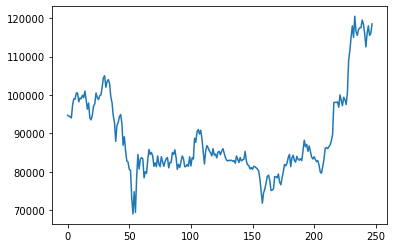

In [171]:
hey[lambda x : x['CODE']=='000660']['adjprice'].plot()

In [169]:
hey[lambda x : x['CODE']=='005930'].tail(1)

,DATE,OPEN,high,low,adjprice,volume,CODE
247,2020-12-30,77400,81300,77300,81000,29417421,005930


In [170]:
np.log(81000) - np.log(55200)

0.38348620138938827

In [175]:
aa = hey[lambda x : x['CODE']=='005930'][['adjprice']]

In [176]:
(1 + aa.pct_change()).cumprod()

,adjprice
0,NaN
1,1.005435
2,1.005435
3,1.010870
4,1.028986
...,...
243,1.338768
244,1.409420
245,1.425725
246,1.418478


In [177]:
np.log(1.467391)

0.38348599398196015

In [180]:
comp[lambda x : x['sector']=='반도체 제조업'].shape

(57, 5)

In [184]:
cdd = list(comp[lambda x : x['sector']=='반도체 제조업'].code.values)

In [186]:
dts = [str(i)+'-12' for i in range(2009,2016)]

In [190]:
itm = ['자산총계','자본총계','당기순이익','영업활동현금흐름','영업이익','매출액']

In [199]:
total = pd.DataFrame(columns=['code','date','itm','type','value'])
for cd in cdd :
    for dt in dts :
        for it in itm :
            tmp = pd.DataFrame([cd,dt,it,'Y',0],index=['code','date','itm','type','value']).T
            total = pd.concat([total,tmp])

In [202]:
total.to_excel("./SemiConductor.xlsx",index=False)

In [187]:
z = pd.read_sql("select * from finance_info_copy where code='005930'",conn)

---

### Dart Past Funda Crawling

In [ ]:
driver_path = "C:/Users/Bae Kyungmo/OneDrive/Desktop/WC_basic/chromedriver.exe"
url = "http://marketdata.krx.co.kr/mdi#document=040402"
download_path = "C:/Users/Bae Kyungmo/Downloads/"
save_path = "C:/Users/Bae Kyungmo/Downloads/"

browser = Chrome(self.driver_path)
browser.maximize_window()
browser.get(self.url)
WebDriverWait(browser, 10).until(EC.element_to_be_clickable((By.XPATH,'//*[@id="schdate8f14e45fceea167a5a36dedd4bea2543"]')))
browser.find_elements_by_xpath('//*[@id="schdate8f14e45fceea167a5a36dedd4bea2543"]')[0].click()
for dt in date_ls:
try:
    pyautogui.moveTo(617, 404)
    pyautogui.doubleClick()
    browser.find_elements_by_xpath('//*[@id="schdate8f14e45fceea167a5a36dedd4bea2543"]')[0].send_keys(dt[:4]+dt[5:7]+dt[8:])
    pyautogui.click(834, 455,duration=1.0)
    time.sleep(2)
    pyautogui.click(1266, 456,duration=1.0)
    try :
        for _ in range(1,20):
            time.sleep(1)
            try :
                os.rename(self.download_path + 'data.csv', self.save_path + 'marcap-{}.csv'.format(dt))

    time.sleep(1)


In [225]:
driver_path = "C:/Users/Bae Kyungmo/OneDrive/Desktop/WC_basic/chromedriver.exe"
browser = Chrome(driver_path)
browser.maximize_window()

In [228]:
driver_path = "C:/Users/Bae Kyungmo/OneDrive/Desktop/WC_basic/chromedriver.exe"
browser = Chrome(driver_path)
browser.maximize_window()
url = "http://dart.fss.or.kr/"
browser.get(url)
#pyautogui.moveTo(785, 361)
pyautogui.click(785, 361,duration=1.0)
browser.find_elements_by_xpath('//*[@id="textCrpNm"]')[0].send_keys('000660')
pyautogui.click(574, 440,duration=1.0)
pyautogui.click(559, 581,duration=1.0)
pyautogui.click(1228, 389,duration=1.0)
pyautogui.click(1332, 379,duration=1.0)

In [229]:
html = BeautifulSoup(browser.page_source, 'html.parser')
#html_Y = html.find('table',{'class':'gHead01 all-width','summary':'주요재무정보를 제공합니다.'})

In [238]:
html.find_all('tbody')[0].find_all('td')[2]

<td>
<a href="/dsaf001/main.do?rcpNo=20200330004441" id="r_20200330004441" onclick="openReportViewer('20200330004441',''); return false;" title="사업보고서 공시뷰어 새창">
<span></span>사업보고서 
								(2019.12)
 								
 							</a>
</td>

---

# Funda From DeepSearch

In [7]:
files = glob.glob("../FinState/반도체 제조업/*")

In [53]:
%%time
non_match={}
for fp in files :
    non = []
    tmp = pd.read_excel(fp,sheet_name=2)
    code = tmp.loc[0,'symbol'].split(':')[-1]
    for dt in sorted(list(set(tmp['date'].values))):
        items = list(tmp[tmp['date']==dt]['name_ko'].values)
        if '자산총계' not in items :
            non.append(dt+'-'+'자산총계')
        elif '자본총계' not in items :
            non.append(dt+'-'+'자본총계')
        elif '당기순이익(손실)' not in items :
            if '당기순이익' not in items :
                flag = False
                for itm in items :
                    if '당기순이익' in itm :
                        flag = True
                if flag == False :
                    non.append(dt+'-'+'당기순이익(손실)|당기순이익')
        elif '영업이익(손실)' not in items :
            flag = False
            for itm in items :
                if '영업이익' in itm :
                    flag = True
            if flag == False :
                non.append(dt+'-'+'영업이익(손실)')
        elif '매출액' not in items or '총수익' not in items :
            if '수익' not in items :
                non.append(dt+'-'+'매출액|총수익|수익')
        elif '영업활동현금흐름' not in items or '영업활동으로인한현금흐름' not in items :
            non.append(dt+'-'+'영업활동현금흐름')
    if len(non)!= 0:
        non_match[code] = non

Wall time: 53.9 s


In [76]:
a1 = pd.read_excel("../FinState/반도체 제조업/DeepSearch-윈팩_IFRS_개별_연간-20210205-114958.xlsx",sheet_name=2)

In [54]:
non_match

{'092590': ['2003-12-31-매출액|총수익|수익',
  '2004-12-31-매출액|총수익|수익',
  '2005-12-31-매출액|총수익|수익',
  '2006-12-31-매출액|총수익|수익',
  '2007-12-31-매출액|총수익|수익',
  '2008-12-31-매출액|총수익|수익',
  '2009-12-31-매출액|총수익|수익',
  '2010-12-31-매출액|총수익|수익',
  '2011-12-31-매출액|총수익|수익',
  '2012-12-31-매출액|총수익|수익',
  '2013-12-31-매출액|총수익|수익',
  '2014-12-31-매출액|총수익|수익',
  '2015-12-31-매출액|총수익|수익',
  '2016-12-31-매출액|총수익|수익',
  '2017-12-31-매출액|총수익|수익',
  '2018-12-31-매출액|총수익|수익',
  '2019-12-31-매출액|총수익|수익'],
 '123860': ['2002-12-31-매출액|총수익|수익', '2003-12-31-매출액|총수익|수익'],
 '059120': ['1997-12-31-영업이익(손실)'],
 '097800': ['2002-12-31-매출액|총수익|수익'],
 '114570': ['2001-12-31-매출액|총수익|수익', '2002-12-31-매출액|총수익|수익']}

092590은 있고 123860은 진짜없네.. 097800은 이상한 수익만 있음...

당기순이익(손실) -> [당기순이익]

영업이익(손실) -> 계속영업이익(손실)

In [95]:
qwe = pd.read_sql("select * from finance_info_copy where code='005930' and date='2019-12'",conn)

In [162]:
%%time
total = pd.DataFrame(columns = ['code','date','itm','type','value','check'])
errs = []
for fp in files :
    tmp = pd.read_excel(fp,sheet_name=2)
    code = tmp.loc[0,'symbol'].split(':')[-1]
    for dt in sorted(list(set(tmp['date'].values))):
        if dt>='2009-12-01' and dt <= '2015-12-31':
            sub = tmp[tmp['date']==dt]
            items = list(sub['name_ko'].values)
            for itm in items :
                try :
                    row_df = pd.DataFrame(columns=['code','date','itm','type','value','check'])
                    row_df.loc[0,'code'] = code
                    row_df.loc[0,'date'] = dt
                    row_df.loc[0,'type'] = 'Y'
                    #print(itm)
                    if '자산총계' in itm :
                        if itm == '자산총계':
                            row_df.loc[0,'itm'] = '자산총계'
                            row_df.loc[0,'value'] = sub[sub['name_ko']=='자산총계']['value'].values[0]
                            row_df.loc[0,'check'] = itm
                            total = pd.concat([total, row_df])
                            continue

                    if '자본총계' in itm :
                        if itm == '자본총계':
                            row_df.loc[0,'itm'] = '자본총계'
                            row_df.loc[0,'value'] = sub[sub['name_ko']=='자본총계']['value'].values[0]
                            row_df.loc[0,'check'] = itm
                            total = pd.concat([total, row_df])
                            continue
                    
                    if '당기순이익(손실)' in itm :
                        if itm == '당기순이익(손실)':
                            row_df.loc[0,'itm'] = '당기순이익'
                            row_df.loc[0,'value'] = sub[sub['name_ko']=='당기순이익(손실)']['value'].values[0]
                            row_df.loc[0,'check'] = '당기순이익(손실)'
                            total = pd.concat([total, row_df])
                            continue
                    else :
                        if '당기순이익(손실)' not in items:
                            if itm == '당기순이익':
                                row_df.loc[0,'itm'] = '당기순이익'
                                row_df.loc[0,'value'] = sub[sub['name_ko']=='당기순이익']['value'].values[0]
                                row_df.loc[0,'check'] = '당기순이익'
                                total = pd.concat([total, row_df])
                                continue
                            elif itm == '[당기순이익]':
                                row_df.loc[0,'itm'] = '당기순이익'
                                row_df.loc[0,'value'] = sub[sub['name_ko']=='[당기순이익]']['value'].values[0]
                                row_df.loc[0,'check'] = '[당기순이익]'
                                total = pd.concat([total, row_df])
                                continue

                    if '영업이익(손실)' in itm :
                        if itm == '영업이익(손실)':
                            row_df.loc[0,'itm'] = '영업이익'
                            row_df.loc[0,'value'] = sub[sub['name_ko']=='영업이익(손실)']['value'].values[0]
                            row_df.loc[0,'check'] = '영업이익(손실)'
                            total = pd.concat([total, row_df])
                            continue
                    else :
                        if '영업이익(손실)' not in items :
                            if itm == '영업이익':
                                row_df.loc[0,'itm'] = '영업이익'
                                row_df.loc[0,'value'] = sub[sub['name_ko']=='영업이익']['value'].values[0]
                                row_df.loc[0,'check'] = '영업이익'
                                total = pd.concat([total, row_df])
                                continue
                            elif itm == '계속영업이익(손실)':
                                row_df.loc[0,'itm'] = '영업이익'
                                row_df.loc[0,'value'] = sub[sub['name_ko']=='계속영업이익(손실)']['value'].values[0]
                                row_df.loc[0,'check'] = '계속영업이익(손실)'
                                total = pd.concat([total, row_df])
                                continue
                            elif itm == '계속영업이익':
                                row_df.loc[0,'itm'] = '영업이익'
                                row_df.loc[0,'value'] = sub[sub['name_ko']=='계속영업이익']['value'].values[0]
                                row_df.loc[0,'check'] = '계속영업이익'
                                total = pd.concat([total, row_df])
                                continue
                    if '매출액' in itm :
                        if itm == '매출액':
                            row_df.loc[0,'itm'] = '매출액'
                            row_df.loc[0,'value'] = sub[sub['name_ko']=='매출액']['value'].values[0]
                            row_df.loc[0,'check'] = itm
                            total = pd.concat([total, row_df])
                            continue
                    else :
                        if '수익' in itm :
                            if '매출액' not in items:
                                if itm == '총수익':
                                    row_df.loc[0,'itm'] = '매출액'
                                    row_df.loc[0,'value'] = sub[sub['name_ko']=='총수익']['value'].values[0]
                                    row_df.loc[0,'check'] = '총수익'
                                    total = pd.concat([total, row_df])
                                    continue
                                else :
                                    if '총수익' not in items and itm == '수익':
                                        row_df.loc[0,'itm'] = '매출액'
                                        row_df.loc[0,'value'] = sub[sub['name_ko']=='수익']['value'].values[0]
                                        row_df.loc[0,'check'] = '수익'
                                        total = pd.concat([total, row_df])
                                        continue
                            
                    if '영업활동현금흐름' in itm or '영업활동으로인한현금흐름' in itm :
                        if itm == '영업활동현금흐름':
                            row_df.loc[0,'itm'] = '영업활동현금흐름'
                            row_df.loc[0,'value'] = sub[sub['name_ko']=='영업활동현금흐름']['value'].values[0]
                            row_df.loc[0,'check'] = '영업활동현금흐름'
                            total = pd.concat([total, row_df])
                            continue
                        elif itm == '영업활동으로인한현금흐름':
                            row_df.loc[0,'itm'] = '영업활동현금흐름'
                            row_df.loc[0,'value'] = sub[sub['name_ko']=='영업활동으로인한현금흐름']['value'].values[0]
                            row_df.loc[0,'check'] = '영업활동으로인한현금흐름'
                            total = pd.concat([total, row_df])
                            continue
                        
                    #total = pd.concat([total, row_df])               
                except Exception as e:
                    print(e)
                    errs.append(fp+'|'+dt+'|'+str(itm))
                    

Wall time: 7min


In [163]:
errs

[]

*실제로 중복이 있네 당기순이익... 무슨 기준인지는 모르겠지만..

일단은 다 쌓고 중복에 대해서 값이 같으면 하나 없애고 다르면... 큰 값으로 하면 되려나..(왠지 지배-비지배 관계일 수도 있을 것 같아서;)

* 317120 라닉스는 진짜로 없네 영업활동(으로인한)현금흐름 자체가... 2017년부터 생겼네...

In [150]:
dup_cd = []
for cd in list(set(total.code.values)):
    for it in ['자산총계','자본총계','매출액','영업이익','당기순이익']:
        qw = total[(total.code==cd)&(total.itm==it)]
        if len(qw)>1 :
            dup_cd.append(cd)
            print('dup'+'-'+cd+'-'+it)
        elif len(qw)==0 :
            print('non'+'-'+cd+'-'+it)

dup-093640-당기순이익
dup-032580-당기순이익
dup-114570-당기순이익
dup-123860-당기순이익
dup-097800-당기순이익
dup-094170-당기순이익
dup-303030-당기순이익
dup-092590-당기순이익
dup-166090-당기순이익
dup-059120-당기순이익
dup-317120-당기순이익
dup-096870-당기순이익


In [156]:
q = pd.read_excel(glob.glob("../FinState/반도체 제조업/*하나머티리얼즈*")[0],sheet_name=2)

In [164]:
total.shape

(1821, 6)

In [165]:
57*7*6

2394

In [197]:
total.head(1)

,code,date,itm,type,value,check
0,000990,2009-12-31,자산총계,Y,2.72662e+12,자산총계


In [172]:
total[(total.code=='000660')&(total.date=='2015-12-31')]

,code,date,itm,type,value,check
0,000660,2015-12-31,자산총계,Y,2.96779e+13,자산총계
0,000660,2015-12-31,자본총계,Y,2.13877e+13,자본총계
0,000660,2015-12-31,매출액,Y,1.8798e+13,총수익
0,000660,2015-12-31,영업이익,Y,5.3361e+12,영업이익(손실)
0,000660,2015-12-31,영업활동현금흐름,Y,9.31952e+12,영업활동으로인한현금흐름
0,000660,2015-12-31,당기순이익,Y,4.3236e+12,당기순이익(손실)


In [180]:
wrongs = []
for cd in list(set(total.code.values)):
    for dt in list(set(total.date.values)):
        if len(total[(total.code==cd)&(total.date==dt)]) > 6:
            if len(total[(total.code==cd)&(total.date==dt)&(total.itm=='당기순이익')]) ==1 :
                wrongs.append(cd+'|dup|'+dt)
        if len(total[(total.code==cd)&(total.date==dt)]) < 6 :
            wrongs.append(cd+'|low|'+dt)

In [182]:
wrongs

['200710|low|2010-12-31',
 '200710|low|2009-12-31',
 '200710|low|2011-12-31',
 '061970|low|2015-12-31',
 '061970|low|2014-12-31',
 '061970|low|2009-12-31',
 '061970|low|2012-12-31',
 '061970|low|2013-12-31',
 '061970|low|2011-12-31',
 '102120|low|2009-12-31',
 '038060|low|2009-12-31',
 '052860|low|2010-12-31',
 '052860|low|2009-12-31',
 '052860|low|2011-12-31',
 '036170|low|2009-12-31',
 '033170|low|2014-12-31',
 '033170|low|2010-12-31',
 '033170|low|2009-12-31',
 '033170|low|2012-12-31',
 '033170|low|2013-12-31',
 '033170|low|2011-12-31',
 '082800|low|2015-12-31',
 '082800|low|2014-12-31',
 '082800|low|2012-12-31',
 '082800|low|2013-12-31',
 '082800|low|2011-12-31',
 '108320|low|2009-12-31',
 '089530|low|2015-12-31',
 '089530|low|2014-12-31',
 '089530|low|2010-12-31',
 '089530|low|2009-12-31',
 '089530|low|2011-12-31',
 '096610|low|2009-12-31',
 '115610|low|2010-12-31',
 '115610|low|2009-12-31',
 '115610|low|2012-12-31',
 '115610|low|2011-12-31',
 '064520|low|2009-12-31',
 '011690|low

In [193]:
whereisit=[]
for e in wrongs:
    sub = total[(total.code==e.split('|')[0])&(total.date==e.split('|')[2])]
    if len(sub) != 0 :
        for it in ['자산총계','자본총계','매출액','영업이익','영업활동현금흐름','당기순이익']:
            if it not in list(sub.itm.values):
                whereisit.append(e.split('|')[0]+'|'+e.split('|')[2]+'|'+it)

In [187]:
wrongs[:5]

['200710|low|2010-12-31',
 '200710|low|2009-12-31',
 '200710|low|2011-12-31',
 '061970|low|2015-12-31',
 '061970|low|2014-12-31']

In [185]:
e

'054450|low|2011-12-31'

In [194]:
len(whereisit), len(wrongs)

(7, 85)

In [195]:
whereisit

['317120|2015-12-31|영업활동현금흐름',
 '317120|2014-12-31|영업활동현금흐름',
 '317120|2010-12-31|영업활동현금흐름',
 '317120|2009-12-31|영업활동현금흐름',
 '317120|2012-12-31|영업활동현금흐름',
 '317120|2013-12-31|영업활동현금흐름',
 '317120|2011-12-31|영업활동현금흐름']

In [196]:
ldr.FindNameByCode('317120')

'라닉스'

In [233]:
total[(total.code=='123860')&(total.itm=='매출액')]

,code,date,itm,type,value,check
0,123860,2009-12-31,매출액,Y,5.53212e+10,총수익
0,123860,2010-12-31,매출액,Y,9.38175e+10,총수익
0,123860,2011-12-31,매출액,Y,1.00723e+11,총수익
0,123860,2012-12-31,매출액,Y,9.81867e+10,총수익
0,123860,2013-12-31,매출액,Y,9.1143e+10,총수익
0,123860,2014-12-31,매출액,Y,1.34041e+11,총수익
0,123860,2015-12-31,매출액,Y,9.94244e+10,총수익


In [236]:
total.head(1)

,code,date,itm,type,value,check
0,000990,2009-12-31,자산총계,Y,2.72662e+12,자산총계


In [239]:
pd.DataFrame().to_hdf("./test.h5",key='test')

In [244]:
total.to_hdf("./FullCache/funda_semiconductor.h5",key='funda')

In [3]:
total = pd.read_hdf("./FullCache/funda_semiconductor.h5")

In [4]:
total.shape

(1821, 6)

In [5]:
total

,code,date,itm,type,value,check
0,000990,2009-12-31,자산총계,Y,2.72662e+12,자산총계
0,000990,2009-12-31,자본총계,Y,6.07545e+11,자본총계
0,000990,2009-12-31,매출액,Y,5.60427e+11,총수익
0,000990,2009-12-31,영업이익,Y,-1.6047e+11,영업이익(손실)
0,000990,2009-12-31,영업활동현금흐름,Y,9.46697e+10,영업활동으로인한현금흐름
...,...,...,...,...,...,...
0,078350,2015-12-31,자본총계,Y,4.587e+10,자본총계
0,078350,2015-12-31,매출액,Y,1.27088e+11,총수익
0,078350,2015-12-31,영업이익,Y,6.86373e+09,영업이익(손실)
0,078350,2015-12-31,영업활동현금흐름,Y,3.48278e+09,영업활동으로인한현금흐름


In [7]:
len(set(total.code.values))

53

In [12]:
total.head(1)

,code,date,itm,type,value,check
0,000990,2009-12-31,자산총계,Y,2.72662e+12,자산총계


In [7]:
semi_codes = list(set(total.code.values))

In [33]:
mcp = pd.read_sql("select * from finance_info_copy where itm='시가총액' and date <= '2016-01' and type='Y' and code in {}".format(tuple(semi_codes)),conn)

In [19]:
set(semi_codes) - set(mcp.code.values)

{'092190', '166090', '317120'}

In [42]:
comp = pd.read_sql("select * from company_info",conn)

In [46]:
def MarcapExtract(codes, td_days, conn):
    errs=[]
    query=[]
    cursor = conn.cursor()
    #year_ls = [str(2010+i) for i in range(11)]
    year_ls = [str(2009)]
    file_path = "./FullCache/marcap/marcap-{}.csv"
    for year in year_ls :
        fpath = file_path.format(year)
        tmp = pd.read_csv(fpath)
        f = lambda x : '{:06d}'.format(x)
        tmp['Code'] = tmp['Code'].map(f)
        
        tmp_codes = list(tmp.Code.values)
        done_codes = list(pd.read_sql("select distinct(code) from finance_info_copy where date='2009-12' and type='Y'",conn).code.values)
        #tmp_codes=['005930']
        
        """Trading date for quarter/annual last day"""
        Q1 = ''#year+'-'+'03-31'
        Q2 = ''#year+'-'+'06-31'
        Q3 = ''#year+'-'+'09-31'
        Y = ''#year+'-'+'12-31'
        for td in td_days :
            if td >= year+'-'+'01-01':
                if td <= year+'-03-31':
                    Q1 = td
                elif td <= year+'-06-31':
                    Q2 = td
                elif td <= year+'-09-31':
                    Q3 = td
                elif td <= year+'-12-31':
                    Y = td
                else :
                    break
                    #raise ValueError("What is this? -> {}".format(td))
        print(Q1, Q2, Q3, Y)
        """Value Extract"""        
        for cd in tmp_codes :
            if cd not in codes :
                continue
            elif cd in done_codes :
                continue
            else :
                #print(cd, end=' ')
                for ith, unit in enumerate([Q1,Q2,Q3,Y]):
                    #print(unit)
                    if ith != 3 :
                        pass
                    else :
                        sub = tmp[(tmp.Code==cd)&(tmp.Date==unit)]
                        if len(sub) == 0 :
                            errs.append(cd+'|'+unit)
                        else :
                            for idx, row in sub.iterrows():
                                if len(pd.read_sql(f"SELECT * FROM finance_info_copy where code='{cd}' and date='{unit[:7]}' and itm='시가총액' and type='Y'",conn)) == 0:
                                    print('--> ',end='')
                                    cursor.execute(f"INSERT INTO finance_info_copy VALUES('{cd}','{unit[:7]}','시가총액','Y',{row.Marcap})")
                                else :
                                    errs.append(cd+'|'+unit)
                                if len(pd.read_sql(f"SELECT * FROM finance_info_copy where code='{cd}' and date='{unit[:7]}' and itm='상장주식수' and type='Y'",conn)) == 0:
                                    cursor.execute(f"INSERT INTO finance_info_copy VALUES('{cd}','{unit[:7]}','상장주식수','Y',{row.Stocks})")
                                else :
                                    errs.append(cd+'|'+unit)
                                conn.commit()
        #conn.commit()
    return errs#, query

In [41]:
with open("./TradingDates.pickle","rb") as fr:
    td_days = pickle.load(fr)

In [47]:
%%time

ers = MarcapExtract(list(comp.code.values), td_days, conn)

2009-03-31 2009-06-30 2009-09-30 2009-12-30
--> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> Wall time: 9min 38s


In [49]:
len(ers)

13661

In [50]:
qqq = pd.read_sql("select * from finance_info_copy where date='2009-12' and type='Y'",conn)

In [52]:
len(set(qqq.code.values))

1353

In [40]:
qwe[(qwe.Code==5930)&(qwe.Date=='2009-12-30')]

,Code,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId,Rank,Date
474705,5930,삼성전자,KOSPI,NaN,799000.0,1,13000.0,1.65,788000.0,799000.0,787000.0,295625.0,2.348286e+11,1.176922e+14,147299337,STK,1,2009-12-30


In [22]:
qwe = pd.read_csv("./FullCache/marcap/marcap-2009.csv")

In [24]:
len(set(qwe.Code.values))

2052

In [54]:
tmp = total.copy()

In [65]:
f_date = lambda x : x[:7]

In [57]:
tmp.head(1)

,code,date,itm,type,value,check
0,000990,2009-12-31,자산총계,Y,2.72662e+12,자산총계


In [66]:
tmp['date'] = tmp['date'].map(f_date)

In [62]:
tmp.iloc[0,1][:7]

'2009-12'

In [75]:
tmp.reset_index(drop=True,inplace=True)

In [88]:
def MoreBStoDB(df, conn):
    errs = []
    cr = conn.cursor()
    for idx, row in df.iterrows():
        try :
            cd = row.code
            dt = row.date
            it = row.itm
            tp = row.type
            val = row.value
            if len(pd.read_sql(f"select * from finance_info_copy where code='{cd}' and date='{dt}' and itm='{it}' and type='Y'",conn))==0:
                qry = f"insert into finance_info_copy values('{cd}','{dt}','{it}','{tp}','{val}')"
                cr.execute(qry)
                conn.commit()
            print('-->',end=' ')
        except Exception as e:
            print(e)
            errs.append(cd+'|'+str(idx))
    return errs

In [89]:
%%time
ers_db = MoreBStoDB(tmp,conn)

--> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> --> 

In [90]:
len(ers_db)

0

In [94]:
tmp.head()

,code,date,itm,type,value,check
0,000990,2009-12,자산총계,Y,2.72662e+12,자산총계
1,000990,2009-12,자본총계,Y,6.07545e+11,자본총계
2,000990,2009-12,매출액,Y,5.60427e+11,총수익
3,000990,2009-12,영업이익,Y,-1.6047e+11,영업이익(손실)
4,000990,2009-12,영업활동현금흐름,Y,9.46697e+10,영업활동으로인한현금흐름


In [97]:
se_codes = list(set(tmp.code.values))

In [100]:
len(se_codes)

53

In [101]:
non = []
for cd in se_codes :
    dates = ['2009-12','2010-12','2011-12','2012-12','2013-12','2014-12','2015-12']
    for dt in dates:
        if len(pd.read_sql(f"select * from finance_info_copy where code='{cd}' and date='{dt}' and itm='시가총액'",conn)) == 0 :
            non.append(cd+'|'+dt)

In [104]:
cr = conn.cursor()
tmp_marcap = f"select value from finance_info_copy where code='000020' and date='2008-12' and type='Y' and itm='시가총액'"
cr.execute(tmp_marcap)
tmp_marcap = cr.fetchone()[0]

TypeError: 'NoneType' object is not subscriptable

In [103]:
len(non)

71

In [109]:
tmp.head(3)

,code,date,itm,type,value,check
0,000990,2009-12,자산총계,Y,2.72662e+12,자산총계
1,000990,2009-12,자본총계,Y,6.07545e+11,자본총계
2,000990,2009-12,매출액,Y,5.60427e+11,총수익


In [112]:
sub = tmp[['code','date','type']].drop_duplicates().reset_index(drop=True)

In [113]:
sub

,code,date,type
0,000990,2009-12,Y
1,000990,2010-12,Y
2,000990,2011-12,Y
3,000990,2012-12,Y
4,000990,2013-12,Y
...,...,...,...
288,078350,2011-12,Y
289,078350,2012-12,Y
290,078350,2013-12,Y
291,078350,2014-12,Y


In [114]:
def IndexCalculator(df, conn):
    errs = []
    cr = conn.cursor()
    for idx, row in df.iterrows():
        try :
            cd = row.code
            dt = row.date
            tp = row.type
            
            tmp_marcap = f"select value from finance_info_copy where code='{cd}' and date='{dt}' and type='{tp}' and itm='시가총액'"
            cr.execute(tmp_marcap)
            tmp_marcap = cr.fetchone()[0]
            tmp_asset = f"select value from finance_info_copy where code='{cd}' and date='{dt}' and type='{tp}' and itm='자산총계'"
            cr.execute(tmp_asset)
            tmp_asset = cr.fetchone()[0]

            tmp_netincome = f"select value from finance_info_copy where code='{cd}' and date='{dt}' and type='{tp}' and itm='당기순이익'"
            cr.execute(tmp_netincome)
            tmp_netincome = cr.fetchone()[0]

            tmp_equity = f"select value from finance_info_copy where code='{cd}' and date='{dt}' and type='{tp}' and itm='자본총계'"
            cr.execute(tmp_equity)
            tmp_equity = cr.fetchone()[0]

            tmp_stocks = f"select value from finance_info_copy where code='{cd}' and date='{dt}' and type='{tp}' and itm='상장주식수'"
            cr.execute(tmp_stocks)
            tmp_stocks = cr.fetchone()[0]

            tmp_ocf = f"select value from finance_info_copy where code='{cd}' and date='{dt}' and type='{tp}' and itm='영업활동현금흐름'"
            cr.execute(tmp_ocf)
            tmp_ocf = cr.fetchone()[0]

            tmp_profit = f"select value from finance_info_copy where code='{cd}' and date='{dt}' and type='{tp}' and itm='영업이익'"
            cr.execute(tmp_profit)
            tmp_profit = cr.fetchone()[0]

            tmp_sales = f"select value from finance_info_copy where code='{cd}' and date='{dt}' and type='{tp}' and itm='매출액'"
            cr.execute(tmp_sales)
            tmp_sales = cr.fetchone()[0]
        
            PBR = tmp_marcap / tmp_equity if tmp_equity != 0 or tmp_equity != None else -999.9
            PER = tmp_marcap / tmp_netincome if tmp_netincome != 0 or tmp_netincome != None else -999.9
            PCR = tmp_marcap / tmp_ocf if tmp_ocf != 0 or tmp_ocf != None else -999.9
            POR = tmp_marcap / tmp_profit if tmp_profit != 0 or tmp_profit != None else -999.9
            PSR = tmp_marcap / tmp_sales if tmp_sales != 0 or tmp_sales != None else -999.9
            ROE = tmp_netincome / tmp_equity if tmp_equity != 0 or tmp_equity != None else -999.9
            ROA = tmp_netincome / tmp_asset if tmp_asset != 0 or tmp_asset != None else -999.9
            EPS = tmp_netincome / tmp_stocks if tmp_stocks != 0 or tmp_stocks != None else -999.9
            BPS = tmp_equity / tmp_stocks if tmp_stocks != 0 or tmp_stocks != None else -999.9
            
            sql = f"insert into finance_info_copy values('{cd}','{dt}','PBR','{tp}',{PBR})"
            cr.execute(sql)
            conn.commit()
            #cr.close()
            sql = f"insert into finance_info_copy values('{cd}','{dt}','PER','{tp}',{PER})"
            cr.execute(sql)
            conn.commit()
            sql = f"insert into finance_info_copy values('{cd}','{dt}','PCR','{tp}',{PCR})"
            cr.execute(sql)
            conn.commit()
            sql = f"insert into finance_info_copy values('{cd}','{dt}','POR','{tp}',{POR})"
            cr.execute(sql)
            conn.commit()
            sql = f"insert into finance_info_copy values('{cd}','{dt}','PSR','{tp}',{PSR})"
            cr.execute(sql)
            conn.commit()
            sql = f"insert into finance_info_copy values('{cd}','{dt}','ROE','{tp}',{ROE})"
            cr.execute(sql)
            conn.commit()
            sql = f"insert into finance_info_copy values('{cd}','{dt}','ROA','{tp}',{ROA})"
            cr.execute(sql)
            conn.commit()
            sql = f"insert into finance_info_copy values('{cd}','{dt}','EPS','{tp}',{EPS})"
            cr.execute(sql)
            conn.commit()
            sql = f"insert into finance_info_copy values('{cd}','{dt}','BPS','{tp}',{BPS})"
            cr.execute(sql)
            conn.commit()
            
            if idx % 1000 == 0:
                print('doing right! :', idx)
        except Exception as e:
            #print(e)
            errs.append([e, idx, row])
            if idx % 300 == 0 :
                print('wrong!!! :',idx)
    #conn.commit()
    print("well done!!")
    return errs

In [115]:
%%time

db_ers = IndexCalculator(sub, conn)

doing right! : 0
well done!!
Wall time: 3.53 s


In [117]:
len(db_ers)

89

In [120]:
pd.read_sql("select * from finance_info_copy where date<='2014-12' and type='Y' and itm not in ('시가총액', '상장주식수','시가총액비중(%)')",conn)

,code,date,itm,type,value
0,000660,2009-12,BPS,Y,1.003883e+04
1,000660,2009-12,EPS,Y,-5.641492e+02
2,000660,2009-12,PBR,Y,2.306047e+00
3,000660,2009-12,PCR,Y,1.018377e+01
4,000660,2009-12,PER,Y,-4.103525e+01
...,...,...,...,...,...
3394,317120,2014-12,당기순이익,Y,1.041680e+08
3395,317120,2014-12,매출액,Y,4.669807e+09
3396,317120,2014-12,영업이익,Y,2.481770e+08
3397,317120,2014-12,자본총계,Y,2.505362e+09


In [121]:
ee = pd.read_hdf("./FullCache/Price/price_2010.h5")

In [122]:
ee

,DATE,OPEN,high,low,adjprice,volume,CODE
0,2010-01-04,7540,7820,7480,7520,177197,000020
1,2010-01-05,7490,7580,7350,7500,214314,000020
2,2010-01-06,7500,7500,7320,7350,81874,000020
3,2010-01-07,7350,7420,7200,7210,106474,000020
4,2010-01-08,7220,7330,7220,7240,61393,000020
...,...,...,...,...,...,...,...
18,2010-12-24,3549,3649,3445,3601,407408,900140
19,2010-12-27,3641,4034,3635,3672,2968495,900140
20,2010-12-28,3649,3714,3524,3644,765946,900140
21,2010-12-29,3599,3749,3556,3601,457168,900140


In [128]:
ee[ee.CODE.isin(semi_codes)].head(2)

,DATE,OPEN,high,low,adjprice,volume,CODE
0,2010-01-04,23350,24150,23350,24100,7346425,000660
1,2010-01-05,24500,24900,23050,23350,12118281,000660


In [125]:
semi_codes = list(comp[lambda x : x['sector']=='반도체 제조업'].code.values)

In [171]:
total = pd.DataFrame(columns=semi_codes)
for fp in glob.glob("./FullCache/Price/*"):
    sub = pd.DataFrame()
    temp = pd.read_hdf(fp)
    temp = temp[temp.CODE.isin(semi_codes)]
    for cd in list(set(temp.CODE.values)):
        tmp = temp[lambda x : x['CODE']==cd][['DATE','adjprice']]
        tmp.index = list(tmp['DATE'].astype(str).values)
        tmp.drop(['DATE'],axis=1,inplace=True)
        tmp.columns = [cd]
        sub = pd.concat([sub,tmp],axis=1)
    total = pd.concat([total,sub])

In [179]:
total.to_hdf("./FullCache/semiconductor_price.h5",key='price')

In [177]:
fundas = pd.read_sql(f"select * from finance_info_copy where code in {tuple(semi_codes)} and type='Y' and itm in ('PBR','PCR','POR','PER','PSR','EPS','BPS','ROE','ROA','시가총액')",conn)

In [183]:
for idx, row in fundas.iterrows():
    if row.date in ['2016-12','2017-12','2018-12','2019-12'] and row.itm in ['EPS','BPS'] :
        fundas.loc[idx,'value'] = fundas.loc[idx,'value'] * 100000000
    elif row.date in ['2016-12','2017-12','2018-12','2019-12'] and row.itm in ['PBR','PER','PCR','POR','PSR']:
        fundas.loc[idx,'value'] = fundas.loc[idx,'value'] / 100000000

In [186]:
fundas.to_hdf("./FullCache/semiconductor_funda.h5",key='funda')

In [192]:
funda_df = pd.DataFrame(index = list(set(fundas.code.values)),columns = ['PBR','PCR','POR','PER','PSR','EPS','BPS','ROE','ROA','시가총액'])

In [194]:
fundas.head(1)

,code,date,itm,type,value
0,000660,2009-12,BPS,Y,10038.82523


In [13]:
def SummaryFundaYearly(tdf, dt):
    # tdf : fundas
    sub = tdf[lambda x : x['date']==dt]
    funda_df = pd.DataFrame(index = list(set(sub.code.values)),columns = ['PBR','PCR','POR','PER','PSR','EPS','BPS','ROE','ROA','시가총액'])
    for idx, row in sub.iterrows():
        funda_df.loc[row.code,row.itm] = row.value
    funda_df.dropna(axis=0,how='any',inplace=True)
    return funda_df.astype(float)

In [199]:
%%time

sfd2009 = SummaryFundaYearly(fundas,'2009-12')

Wall time: 1.24 s


In [201]:
sfd2009.shape

(55, 10)

In [3]:
def Labeling(df, qtl=5):
    """Summary df should be inserted"""
    rst = df.copy()
    for c in df.columns :
        tmp_dict = {}
        for i, e in enumerate(list(df.groupby(pd.qcut(df[c],qtl)).agg(['mean']).index)):
            tmp_dict[e] = i+1
        rst[c] = pd.qcut(df[c],qtl).map(tmp_dict)
    return rst

In [4]:
def Stationarity_Test_Ticker(pr, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    assert pr.shape[1] == 1
    cd = pr.columns[0]
    try :
        sub_df = pr[[cd]].dropna(axis=0)
        pvalue = adfuller(sub_df[cd])[1]
        if pvalue < cutoff:
            return False
        else :
            return True
    except Exception as e:
        print(e)
        return False

In [5]:
def Cointegrated_Pairs(data, cutoff=0.01):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < cutoff:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [6]:
def AnnualSectorDist_v5(fn_label, pr, dt, sc, initial=True, doplot=False):
    """sc_df_ls = [sc2016,sc2017,sc2018,sc2019]"""
    rst = pd.DataFrame(columns=['Date','Funda','C31-Best','C31-Count','Dominant'])
    year = int(dt[:4])
    if year == 2019 :
        start = str(year+1)+'-03-31'
        end = str(year+1)+'-12-31'
    else :
        start = str(year+1)+'-03-31'
        end = str(year+2)+'-02-28'
    for fd in ['PBR','PCR','POR','PSR','PER','EPS','BPS','ROE','ROA','시가총액']:
        tmp = pd.DataFrame(index=[sc],columns=['Date','Funda','C31-Best','C31-Count','Dominant'])
        mer_total = pd.DataFrame()
        if initial and doplot:
            plt.figure(figsize=(16,12))
            plt.title("Total Expected Return in sector {} with {}".format(sc,fd))
            plt.xlabel(f"{fd} with 3 quantile")
            plt.ylabel('Expected Return Rate')
        for ith in ['1','2','3']:
            sc_idx = list(fn_label[lambda x : x[fd]==int(ith)].index)
            sub_pr = pr[sc_idx]
            sub_pr = sub_pr.dropna(axis=1,how='any')
            er = GetExpectedReturn_v2(sub_pr,initial)
            am_pr = pd.DataFrame(er.T.mean(), columns=[fd+'-'+ith])
            mer_total = pd.concat([mer_total, am_pr],axis=1).dropna(axis=0,how='any')
            if initial and doplot:
                plt.plot(list(sub_pr.index), am_pr[fd+'-'+ith].values, linestyle='--', label='{}-{}-Quantile'.format(fd,ith))
        if initial and doplot:
            plt.legend(loc='upper left')
            plt.grid(True)
            plt.show()
        x = y = z = 0
        for d in list(mer_total.index):
            idx = mer_total.loc[d].idxmax()
            if idx == fd+'-1': x+=1
            elif idx == fd+'-2' : y+=1
            elif idx == fd+'-3' : z+=1
            else : raise ValueError("Can't be !!!")
        var = {x:'1', y:'2', z:'3'}
        tmp.loc[sc,'C31-Best'] = var.get(max(var))
        tmp.loc[sc,'C31-Count'] = [x,y,z]
        tmp.loc[sc,'Date'] = dt
        tmp.loc[sc,'Funda'] = fd
        tmp_ls = [x,y,z]
        try :
            tmp_ls = [x/sum(tmp_ls), y/sum(tmp_ls), z/sum(tmp_ls)]
        except :
            tmp_ls = [x,y,z]
        flag = 'N'
        for e in tmp_ls :
            if e >= 0.65 :
                flag='Y'
        tmp.loc[sc,'Dominant'] = flag
        
        rst = pd.concat([rst,tmp])
                
    return rst

In [7]:
def FilteringBySector(dt, sc, by=None):
        conn = pymysql.connect(host='localhost',user='root',
                                   password='tlqkfdk2',db='INVESTAR',charset='utf8')
        code_ls = list(pd.read_sql(f"select code from company_info where sector='{sc}'",conn).code.values)
        print("*Original number of comps : {}".format(len(code_ls)))
        """Basic Filtering"""
        # 자본 총계가 하위 50% or 연평균(?합?) 거래량이 하위 30% 
        """일단 전체 시장에서의 상대적인 값으로 생각하자"""
        tdf = pd.read_sql(f"select * from finance_info_copy where date='{dt}' and itm='자본총계'",conn)
        tdf['value'] = tdf['value'].astype(float)
        equity_half = tdf['value'].quantile(q=0.3, interpolation='nearest')
        equity_half_ls = set(tdf[lambda x : x['value']<=equity_half].code.values)
        excluded_ls = list(set(equity_half_ls).intersection(set(code_ls)))
        excluded_ls.append('|')
        code_ls = list(set(code_ls) - equity_half_ls)
        print("*Equity Filtered number of comps : {}".format(len(code_ls)))
        
        df = pd.read_sql(f"select code, date, volume from daily_price where date between '{dt[:4]+'-01-01'}' and '{dt[:4]+'-12-31'}'",conn)
        df = df.fillna(0)
        volume_30 = df.groupby(by='code').mean()['volume'].quantile(q=0.2,interpolation='nearest')
        volume_30_ls = set(df[lambda x : x['volume']<=volume_30].code.values)
        excluded_ls += list(set(volume_30_ls).intersection(set(code_ls)))
        excluded_ls.append('|')
        code_ls = list(set(code_ls) - volume_30_ls)
        print("*Volume Filtered number of comps : {}".format(len(code_ls)))
        
        if by == None :
            return code_ls, excluded_ls
        else :
            for e in by :
                if e == 'PBR':
                    df = pd.read_sql(f"select * from finance_info_copy where date='{dt}' and itm='PBR'",conn)
                    code_ls = list(set(code_ls) - set(df[lambda x : x['value']<0].code.values))
                elif e == 'PCR':
                    df = pd.read_sql(f"select * from finance_info_copy where date='{dt}' and itm='PCR'",conn)
                    code_ls = list(set(code_ls) - set(df[lambda x : x['value']<0].code.values))
                    df = pd.read_sql(f"select * from finance_info_copy where date='{dt}' and itm='영업활동현금흐름'",conn)
                    code_ls = list(set(code_ls) - set(df[lambda x : x['value']<0].code.values))
                    small_cfc = []
                    for cd in list(set(df.code.values)):
                        try :
                            if df[(df.code==cd)]['value'].values[0] <= tdf[(tdf.code==cd)]['value'].values[0] * 0.01:
                                small_cfc.append(cd)
                        except :
                            pass
                    code_ls = list(set(code_ls) - set(small_cfc))
                elif e == 'POR':
                    df = pd.read_sql(f"select * from finance_info_copy where date='{dt}' and itm='POR'",conn)
                    code_ls = list(set(code_ls) - set(df[lambda x : x['value']<0].code.values))
                    df = pd.read_sql(f"select * from finance_info_copy where date='{dt}' and itm='영업이익'",conn)
                    code_ls = list(set(code_ls) - set(df[lambda x : x['value']<0].code.values))
                    small_profit = []
                    for cd in list(set(df.code.values)):
                        try :
                            if df[(df.code==cd)]['value'].values[0] <= tdf[(tdf.code==cd)]['value'].values[0] * 0.01:
                                small_profit.append(cd)
                        except :
                            pass
                    code_ls = list(set(code_ls) - set(small_profit))
                else :
                    raise ValueError("Can't be !!")
            return code_ls, excluded_ls

In [52]:
def Picker_v1(dt='2019-12', sc='반도체 제조업',doplot=False):
    """Step0 : Default Setting """
    print("============== Step0 ================")
    year = int(dt[:4])
    start = str(year+1)+'-03-31'
    if year != 2019:
        end = str(year+2)+'-02-28'
    else :
        end = '2020-12-31'
    conn = pymysql.connect(host='localhost',user='root', password='tlqkfdk2',db='INVESTAR',charset='utf8')
    sc_ls = list(pd.read_sql("select code, sector from company_info", conn)[lambda x : x['sector']==sc].code.values)
    pr = pd.read_hdf("./FullCache/semiconductor_price.h5")
    pr.dropna(axis=1, how='all',inplace=True)
    
    """Step1 : Filtering """
    print("============== Step1 ================")
    #basic_fltr, _ = FilteringBySector(dt, sc, by=None)
    basic_fltr = list(pr.columns)
    """Step2 : Non-Stationarity """
    print("============== Step2 ================")
    non_stat = []
    for cd in basic_fltr :
        try :
            if Stationarity_Test_Ticker(pr[[cd]], cutoff=0.05):
                non_stat.append(cd)
        except :
            pass
    if len(non_stat)==0:
        raise ValueError("None of stocks is non-stationary...")
    else :
        print("*Non-Stationarity Filtered number of comps : {}".format(len(non_stat)))
    
    """Step3 : Funda Quantile """
    print("============== Step3 ================")
   # tdf = pd.read_hdf("./FullCache/funda_semiconductor.h5")
   # f = lambda x : x[:7]
   # tdf['date'] = tdf['date'].map(f)
    items = ['PBR','PCR','POR','PER','PSR','EPS','BPS','ROE','ROA','시가총액']
    tdf = pd.read_sql(f"select * from finance_info_copy where code in {tuple(non_stat)} and date='{dt}' and itm in {tuple(items)}",conn)
    fn = SummaryFundaYearly(tdf,dt)
    fn = fn[fn.index.isin(non_stat)]
    
    print("Funda-existence Filtered number of comps : {}".format(len(fn)))
    fn_label = Labeling(fn, 3)
    
    """Step4 : Funda to Best ER """
    print("============== Step4 ================")
    rst_init_Y = AnnualSectorDist_v5(fn_label, pr, dt, sc, initial=True, doplot=doplot)
    #rst_init_N = AnnualSectorDist_v5(fn_label, pr, dt, sc, initial=False)
    
    """Step5 : CoInteg Pairs """
    print("============== Step5 ================")
    _,_, pairs = Cointegrated_Pairs(pr[list(fn.index)].dropna(axis=1,how='any'),cutoff=0.05) #빼야하나..
    
    return rst_init_Y, pairs, fn, fn_label

In [9]:
def GetExpectedReturn_v2(df, initial=True):
    if initial:
        start_date = df.index[0]
        with open("./TradingDates.pickle","rb") as fr :
            td_days = pickle.load(fr)
        idx = td_days.index(df.index[0])
        dates = td_days[idx-19:idx+1]
        sub_df = ldr.GetPrice(dates[0],dates[-1],list(df.columns),item='adjprice',colname='code')
        tdf = df.copy()
        tdf.iloc[0,:] = sub_df.mean().values
        return (tdf - tdf.iloc[0,:]) / tdf.iloc[0,:]
    else :
        return ((df - df.shift(1)) / df.shift(1)).fillna(0)

In [53]:
%%time

a1 = Picker_v1('2009-12',sc='반도체 제조업',doplot=False)

============== Step0 ================
============== Step1 ================
============== Step2 ================
*Non-Stationarity Filtered number of comps : 39
============== Step3 ================
Funda-existence Filtered number of comps : 13
============== Step4 ================
============== Step5 ================
Wall time: 19.1 s


In [39]:
def SummaryFundaYearly(tdf, dt):
    # tdf : fundas
    sub = tdf[lambda x : x['date']==dt]
    funda_df = pd.DataFrame(index = list(set(sub.code.values)),columns = ['PBR','PCR','POR','PER','PSR','EPS','BPS','ROE','ROA','시가총액'])
    for idx, row in sub.iterrows():
        funda_df.loc[row.code,row.itm] = row.value
    funda_df.dropna(axis=0,how='any',inplace=True)
    return funda_df.astype(float)

In [36]:
qwe = pd.read_sql(f"select * from finance_info_copy where code in {tuple(non_stat)} and date='{dt}' and itm in {tuple(zz)}",conn)

In [44]:
qq = SummaryFundaYearly(qwe,'2009-12')

In [46]:
qq.shape

(21, 10)

In [47]:
fn_label = Labeling(qq, 3)

In [143]:
def PatternChecker(dt='2019-12', sc='반도체 제조업',doplot=False):
    """Step0 : Default Setting """
    print("============== Step0 ================")
    year = int(dt[:4])
    start = str(year+1)+'-02-03'
    if year != 2019:
        end = str(year+2)+'-01-31'
    else :
        end = '2020-12-31'
    conn = pymysql.connect(host='localhost',user='root', password='tlqkfdk2',db='INVESTAR',charset='utf8')
    sc_ls = list(pd.read_sql("select code, sector from company_info", conn)[lambda x : x['sector']==sc].code.values)
    pr = pd.read_hdf("./FullCache/semiconductor_price.h5")
    pr = pr[(pr.index>=start)&(pr.index<=end)]
    pr.dropna(axis=1, how='all',inplace=True)
    
    items = ['PBR','PCR','POR','PER','PSR','EPS','BPS','ROE','ROA','시가총액']
    tdf = pd.read_sql(f"select * from finance_info_copy where code in {tuple(sc_ls)} and date='{dt}' and itm in {tuple(items)}",conn)
    fn = SummaryFundaYearly(tdf,dt)
    
    print("Initial number of comps : {}".format(len(sc_ls)))
    print("Funda-existence Filtered number of comps : {}".format(len(fn)))
    fn_label = Labeling(fn, 3)
    
    """Step4 : Funda to Best ER """
    #print("============== Step4 ================")
    rst_init_Y,_ = AnnualSectorDist_v6(fn_label, pr, dt, sc, cum_mode=True, doplot=doplot)
    
    """Step5 : CoInteg Pairs """
    print("============== Step5 ================")
    #_,_, pairs = Cointegrated_Pairs(pr[list(fn.index)].dropna(axis=1,how='any'),cutoff=0.05) #빼야하나..
    
    return rst_init_Y, fn, fn_label

In [142]:
def AnnualSectorDist_v6(fn_label, pr, dt, sc, cum_mode=True, doplot=False):
    """sc_df_ls = [sc2016,sc2017,sc2018,sc2019]"""
    rst = pd.DataFrame(columns=['Date','Funda','C31-Best','C31-Count','Dominant'])
    year = int(dt[:4])
    if year == 2019 :
        start = str(year+1)+'-02-03'
        end = str(year+1)+'-12-31'
    else :
        start = str(year+1)+'-02-03'
        end = str(year+2)+'-01-31'
    summary_df = pd.DataFrame(index=[dt],columns=['itm','1','2','3'])
    for fd in ['PBR','PCR','POR','PSR','PER','EPS','BPS','ROE','ROA','시가총액']:
        tmp = pd.DataFrame(index=[sc],columns=['Date','Funda','C31-Best','C31-Count','Dominant'])
        mer_total = pd.DataFrame()
        if cum_mode and doplot:
            plt.figure(figsize=(16,12))
            plt.title("CumMode : {} | Expected Return in sector {} with {}".format(cum_mode,sc,fd))
            plt.xlabel(f"{fd} with 3 quantile")
            plt.ylabel('Expected Return Rate')
        for ith in ['1','2','3']:
            sc_idx = list(fn_label[lambda x : x[fd]==int(ith)].index)
            sub_pr = pr[sc_idx]
            sub_pr = sub_pr.dropna(axis=1,how='any')
            er = GetExpectedReturn_v3(sub_pr,cum_mode)
            am_pr = pd.DataFrame(er, columns=[fd+'-'+ith])
            mer_total = pd.concat([mer_total, am_pr],axis=1).dropna(axis=0,how='any')
            if cum_mode and doplot:
                plt.plot(list(sub_pr.index)[1:], am_pr[fd+'-'+ith].values, linestyle='--', label='{}-{}-Quantile'.format(fd,ith))
        if cum_mode and doplot:
            plt.legend(loc='upper left')
            plt.grid(True)
            plt.show()
        x = y = z = 0
        for d in list(mer_total.index):
            idx = mer_total.loc[d].idxmax()
            if idx == fd+'-1': x+=1
            elif idx == fd+'-2' : y+=1
            elif idx == fd+'-3' : z+=1
            else : raise ValueError("Can't be !!!")
        var = {x:'1', y:'2', z:'3'}
        tmp.loc[sc,'C31-Best'] = var.get(max(var))
        tmp.loc[sc,'C31-Count'] = [x,y,z]
        tmp.loc[sc,'Date'] = dt
        tmp.loc[sc,'Funda'] = fd
        tmp_ls = [x,y,z]
        try :
            tmp_ls = [x/sum(tmp_ls), y/sum(tmp_ls), z/sum(tmp_ls)]
        except Exception as e:
            print(e)
            tmp_ls = [x,y,z]
        flag = 'N'
        for e in tmp_ls :
            if e >= 0.65 :
                flag='Y'
        tmp.loc[sc,'Dominant'] = flag
        
        rst = pd.concat([rst,tmp])
        itm_sum = pd.DataFrame(index=[dt],columns=['itm','1','2','3'])
        itm_sum.loc[dt,'itm'] = fd
        itm_sum.loc[dt,'1'] = mer_total.iloc[-1,0]
        itm_sum.loc[dt,'2'] = mer_total.iloc[-1,1]
        itm_sum.loc[dt,'3'] = mer_total.iloc[-1,2]
        summary_df = pd.concat([summary_df, itm_sum])
                
    return rst, summary_df

In [127]:
def GetExpectedReturn_v3(pr, cum_mode=True):
    if cum_mode:
        return np.log(pr.pct_change().dropna(axis=0).T.mean()+1).cumsum()
    else :
        return np.log(pr.pct_change().dropna(axis=0).T.mean()+1)

============== Step0 ================
Initial number of comps : 57
Funda-existence Filtered number of comps : 21


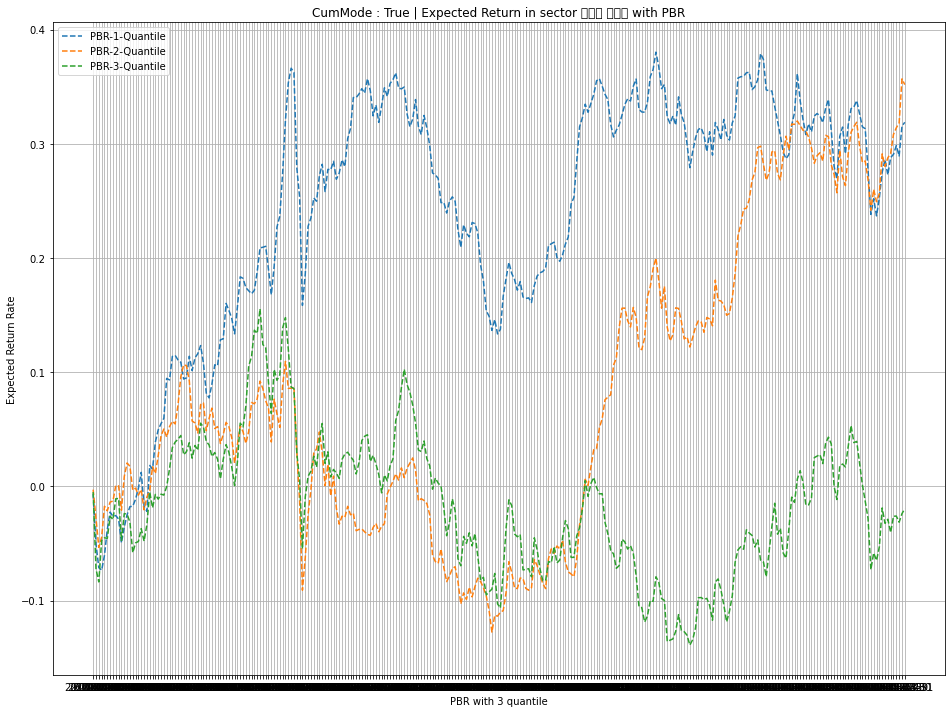

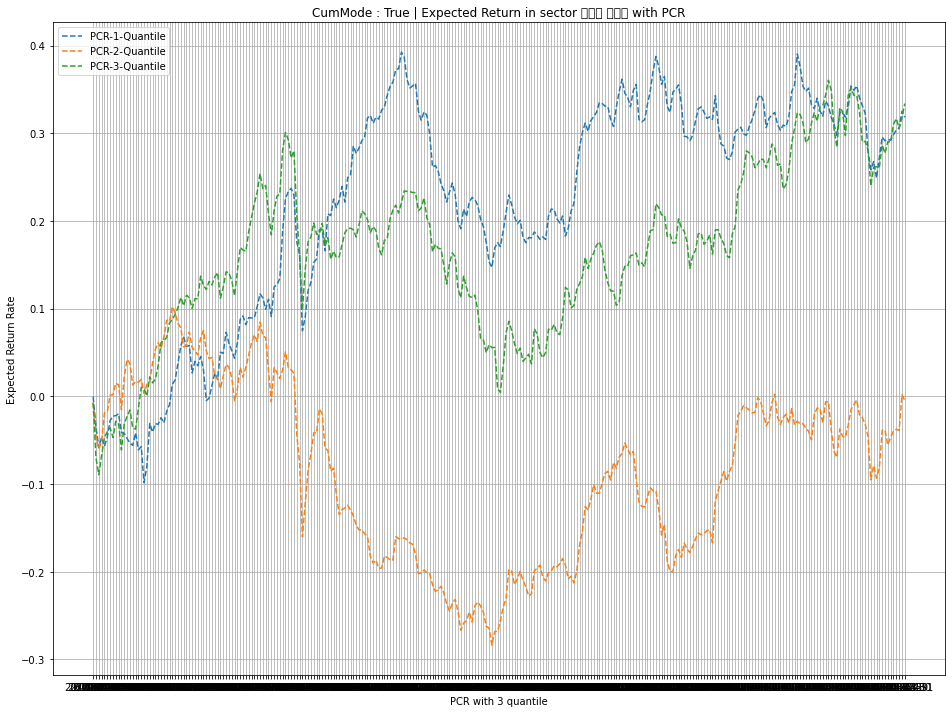

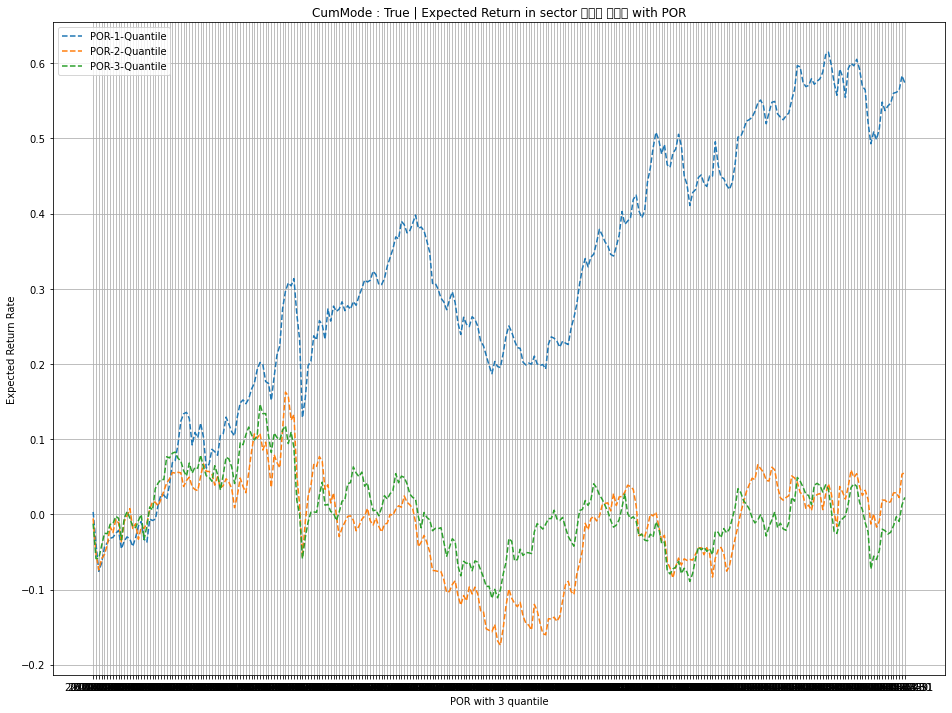

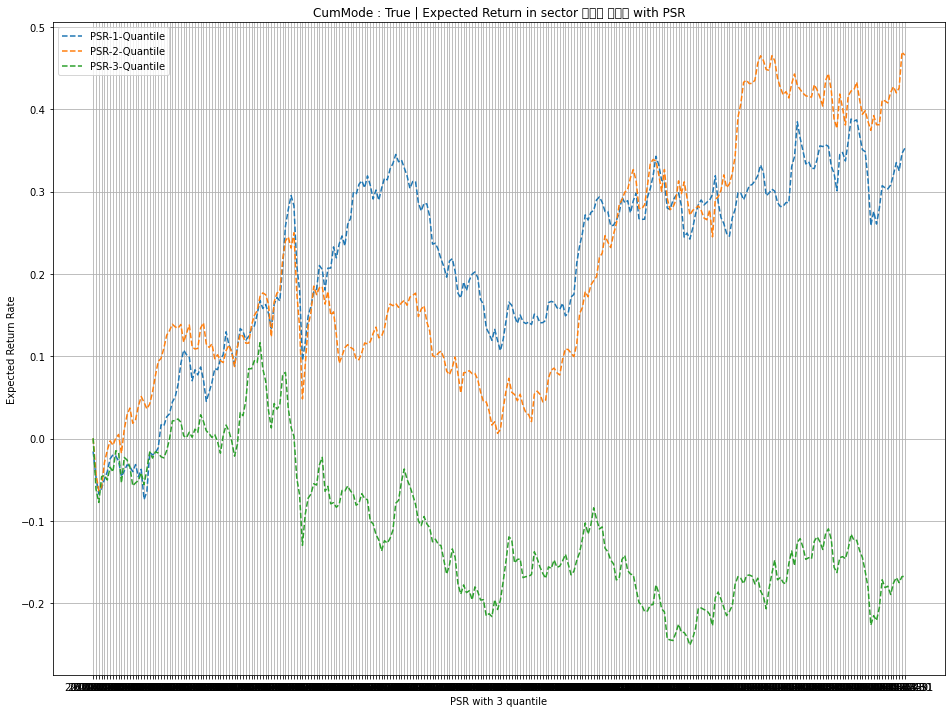

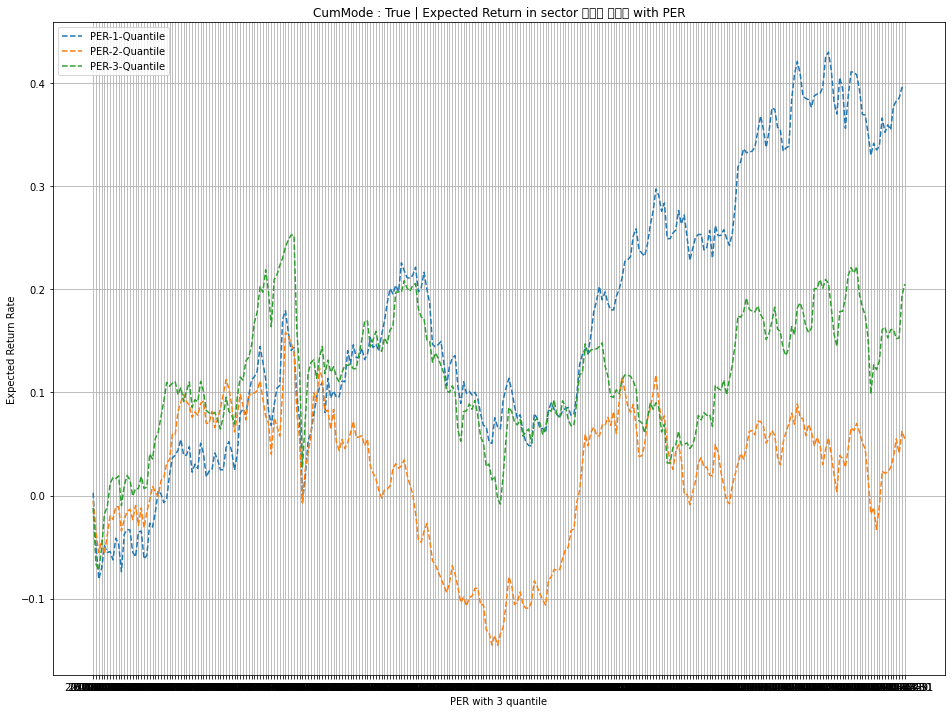

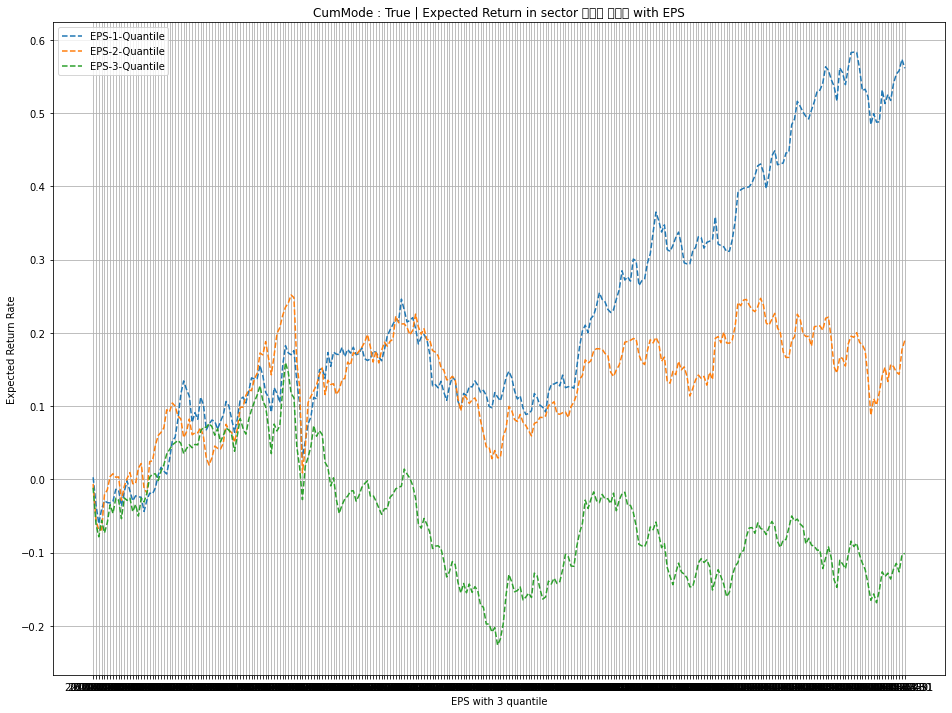

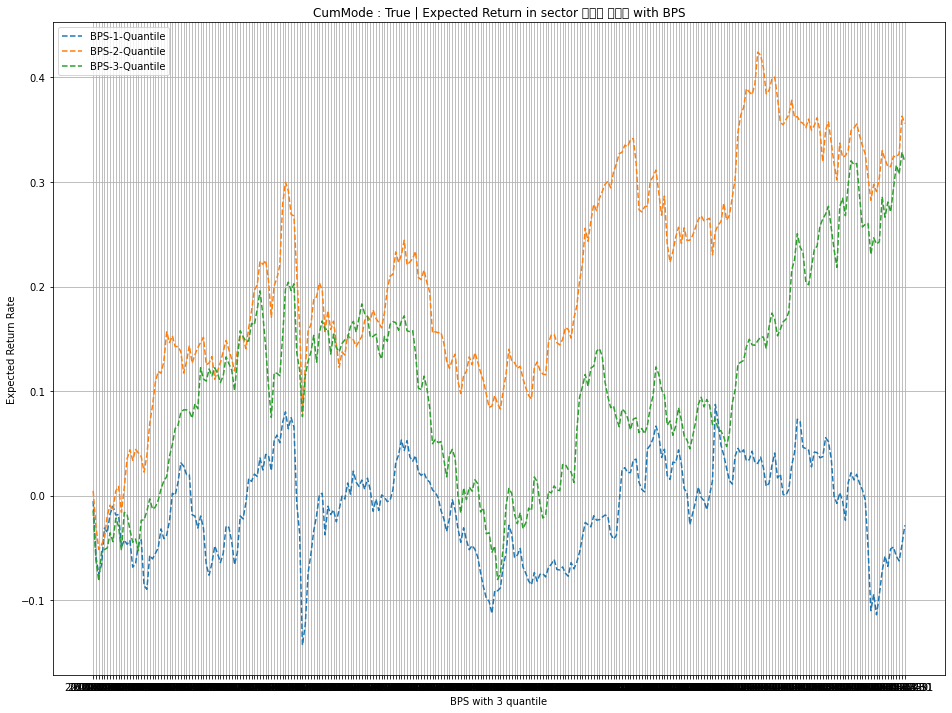

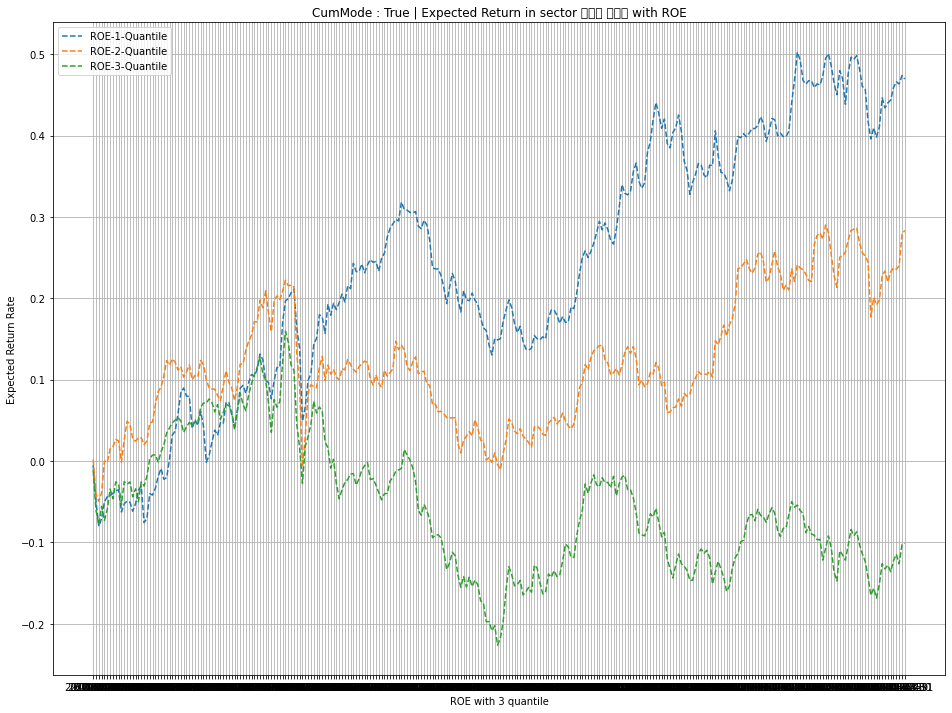

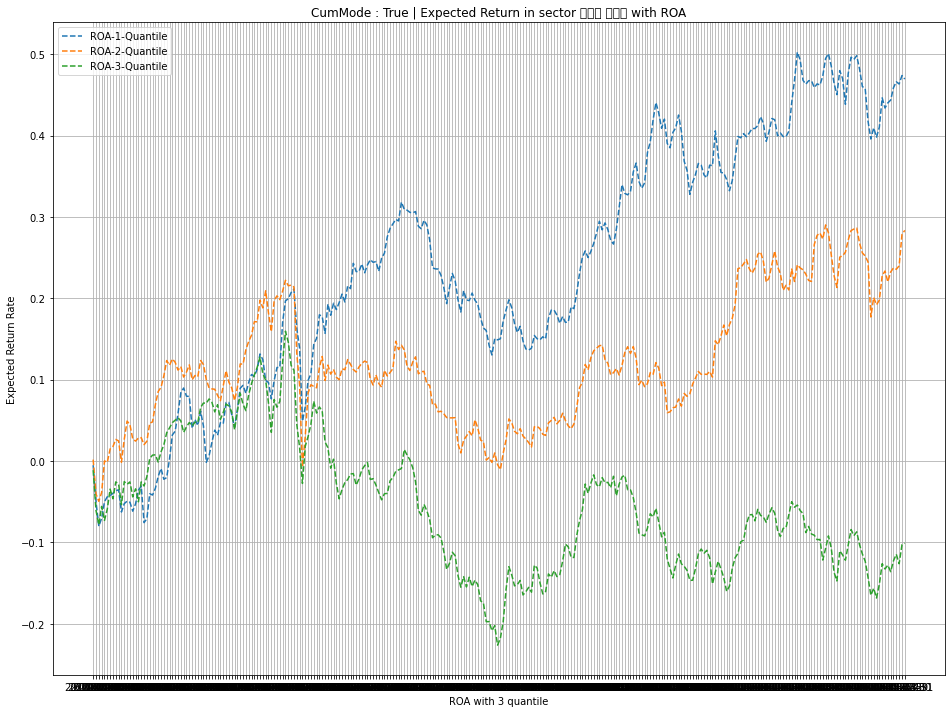

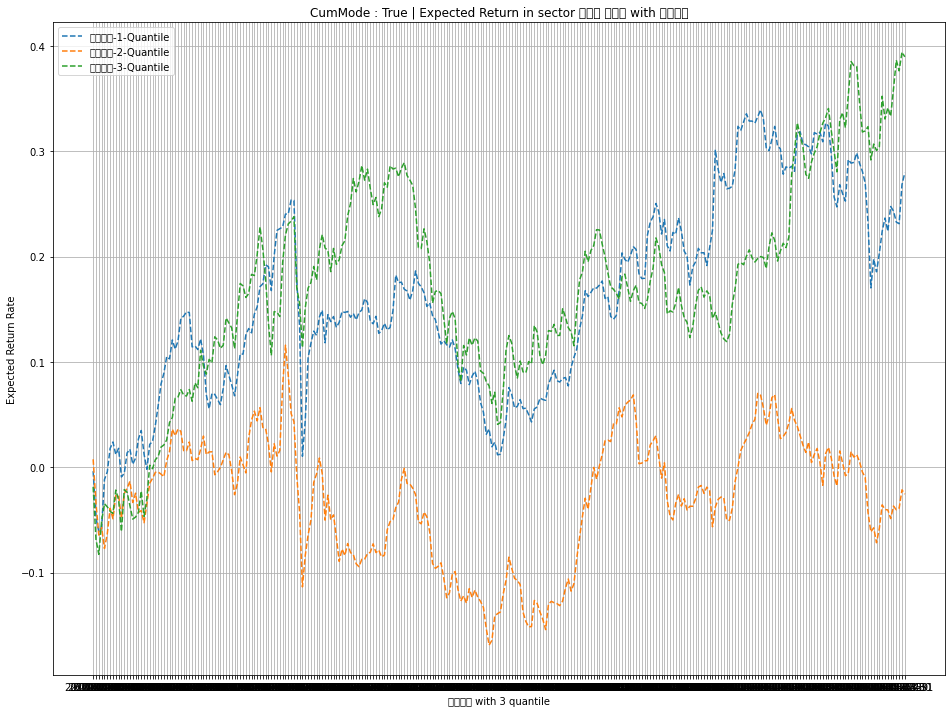

============== Step5 ================
Wall time: 1min 17s


In [128]:
%%time
dt='2009-12'
a1 = PatternChecker(dt, sc='반도체 제조업', doplot=True)

============== Step0 ================
Initial number of comps : 57
Funda-existence Filtered number of comps : 36


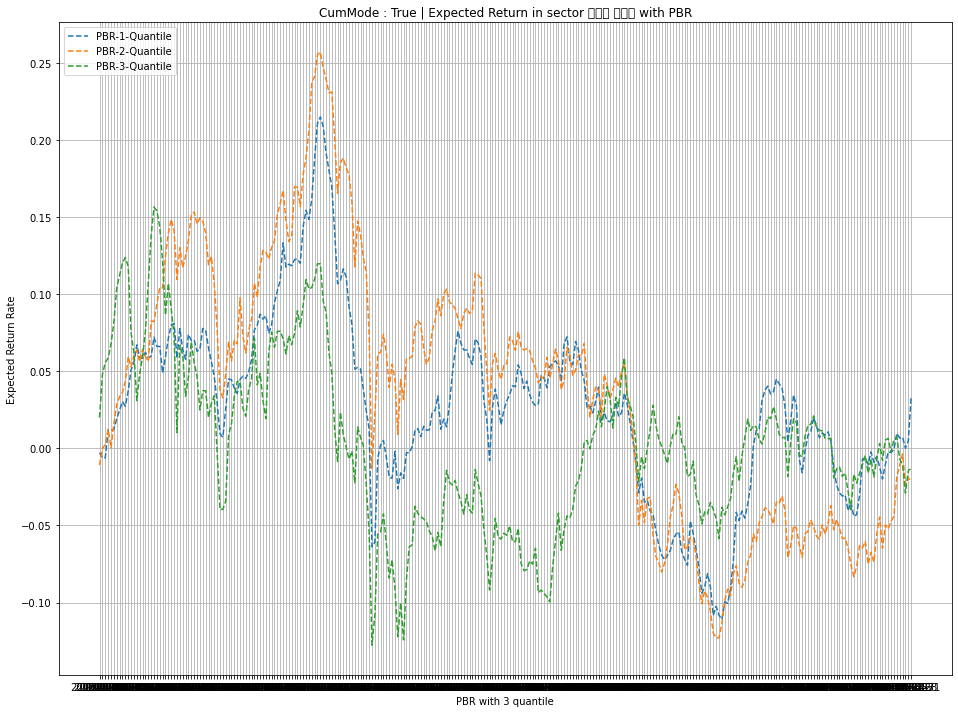

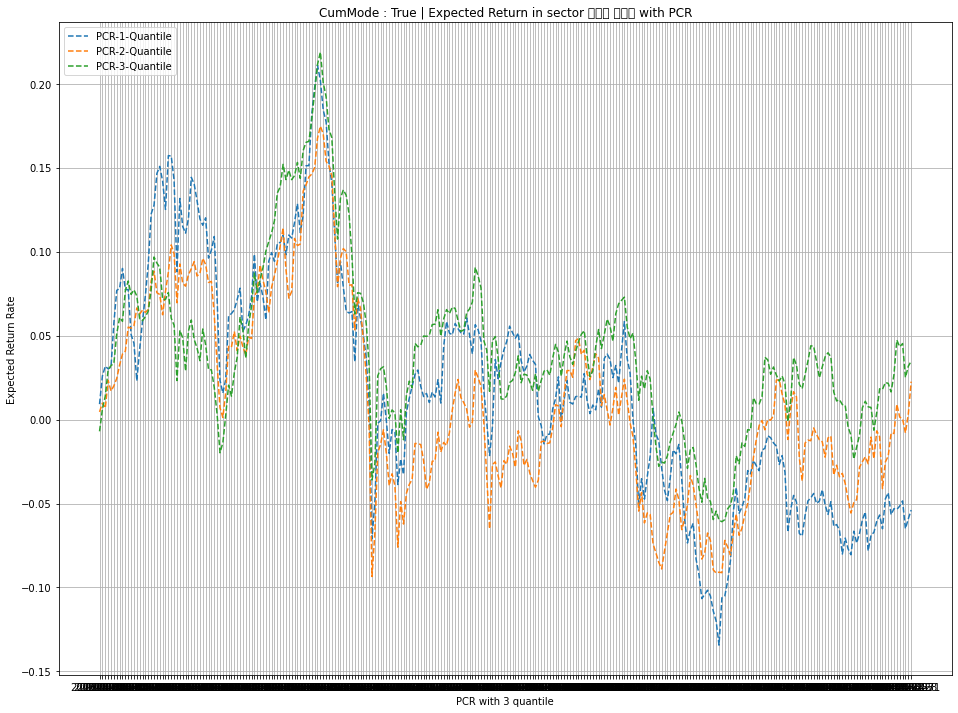

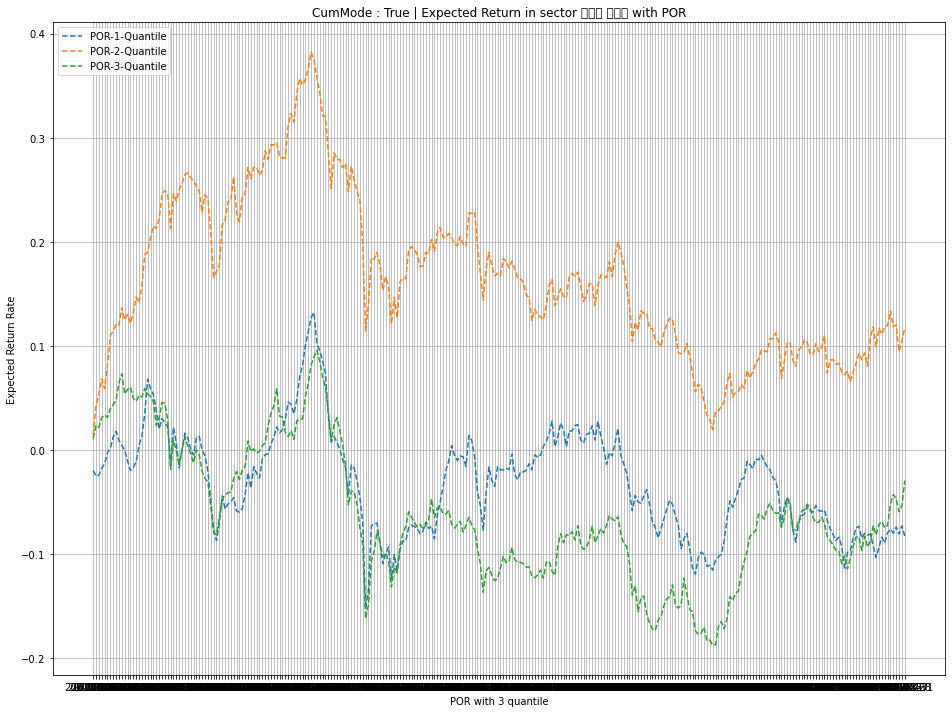

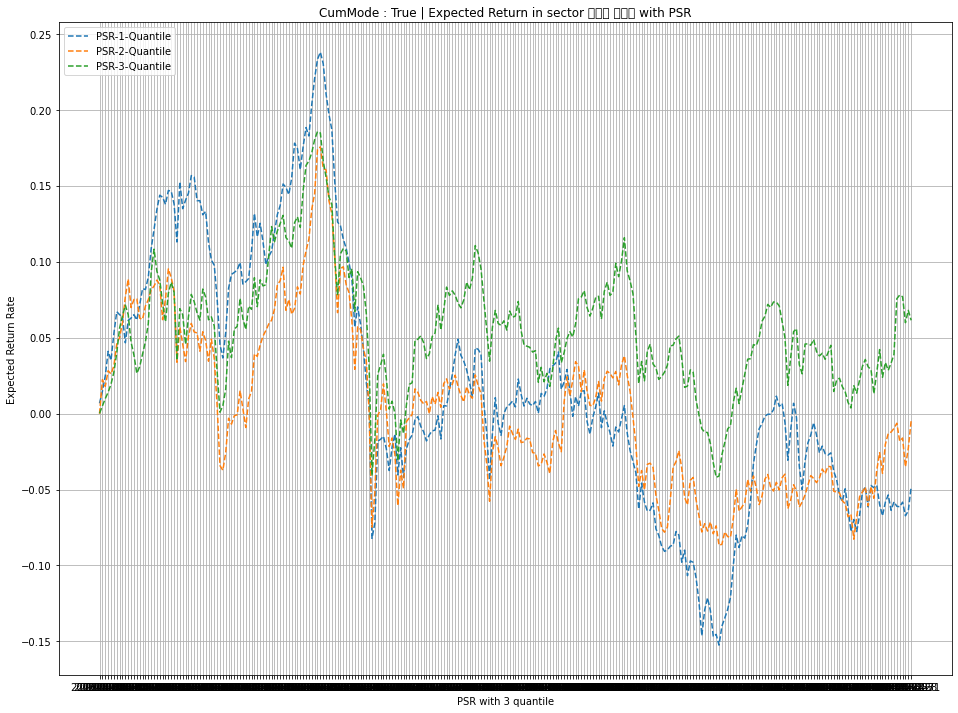

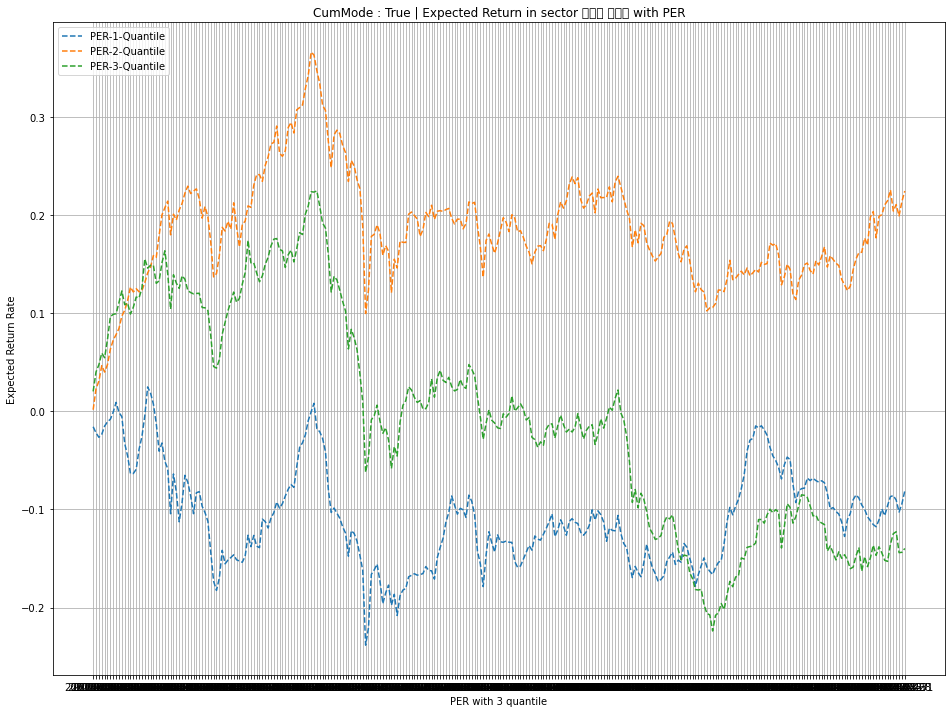

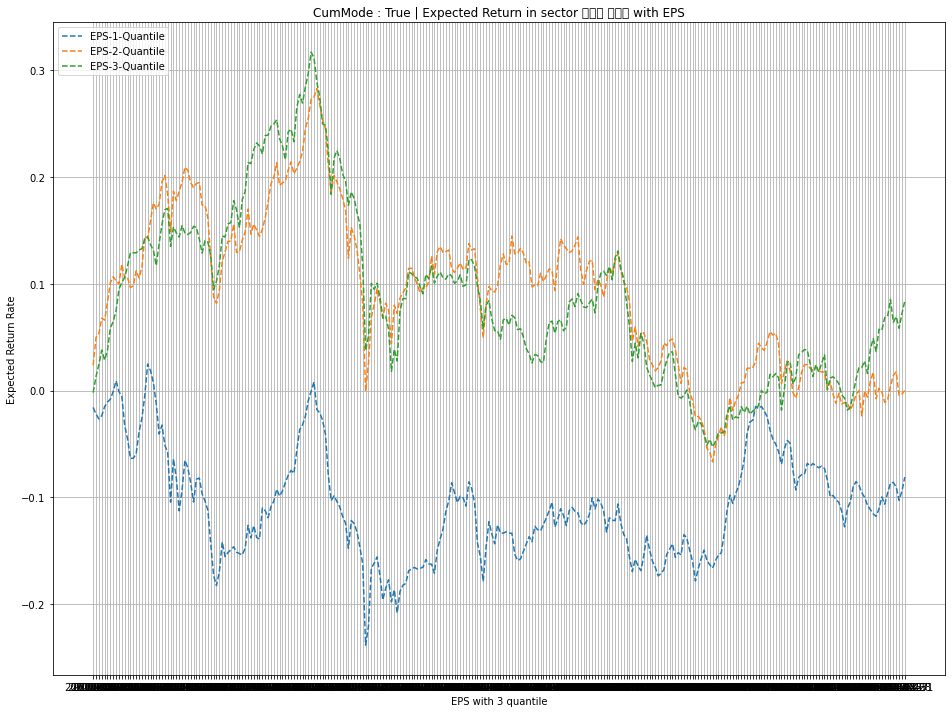

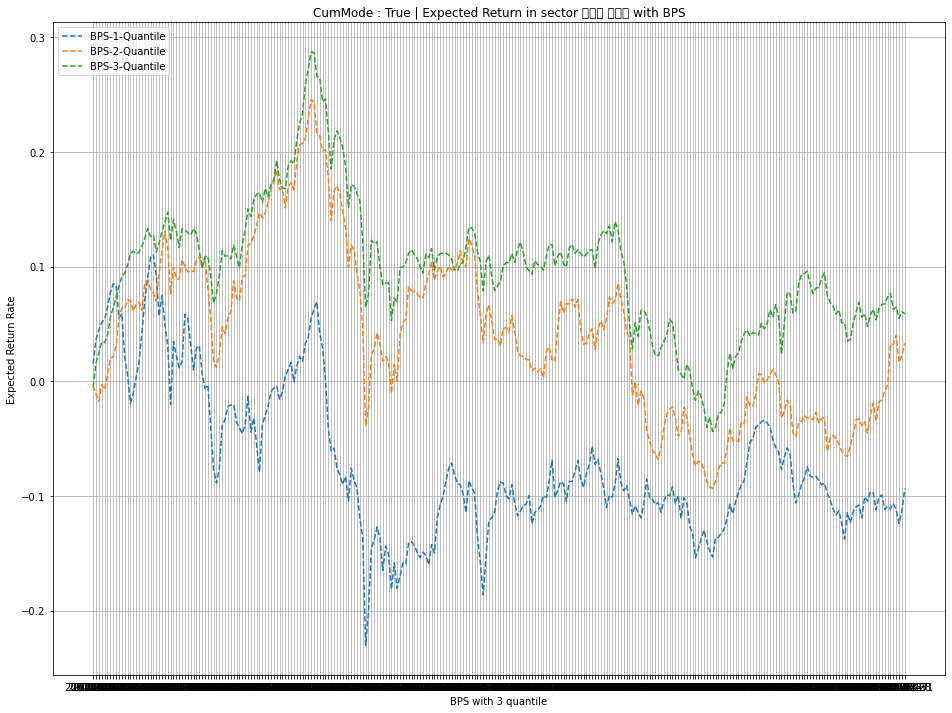

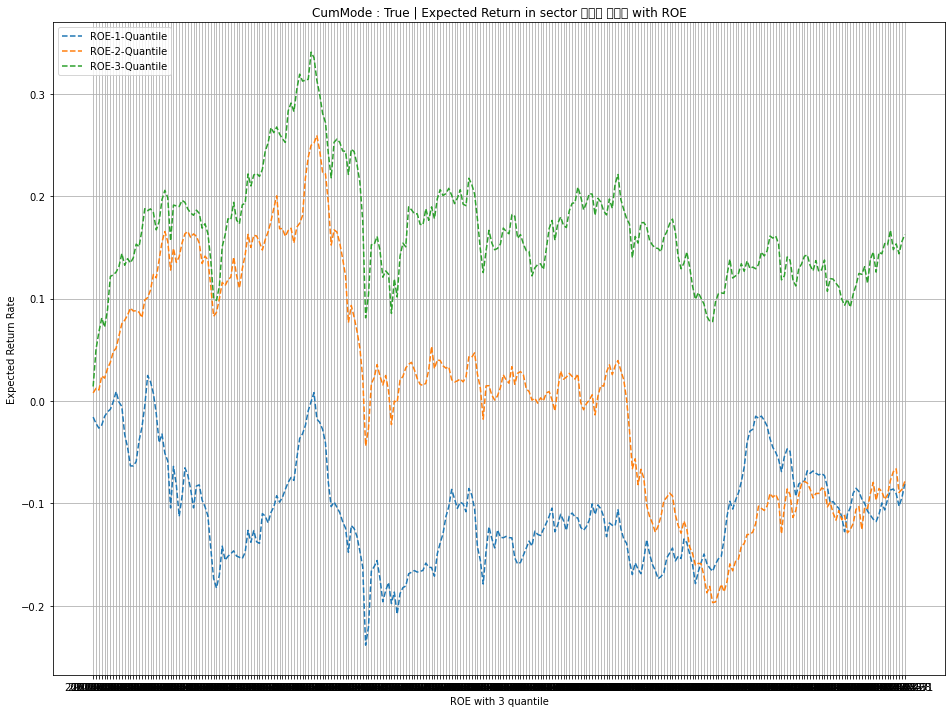

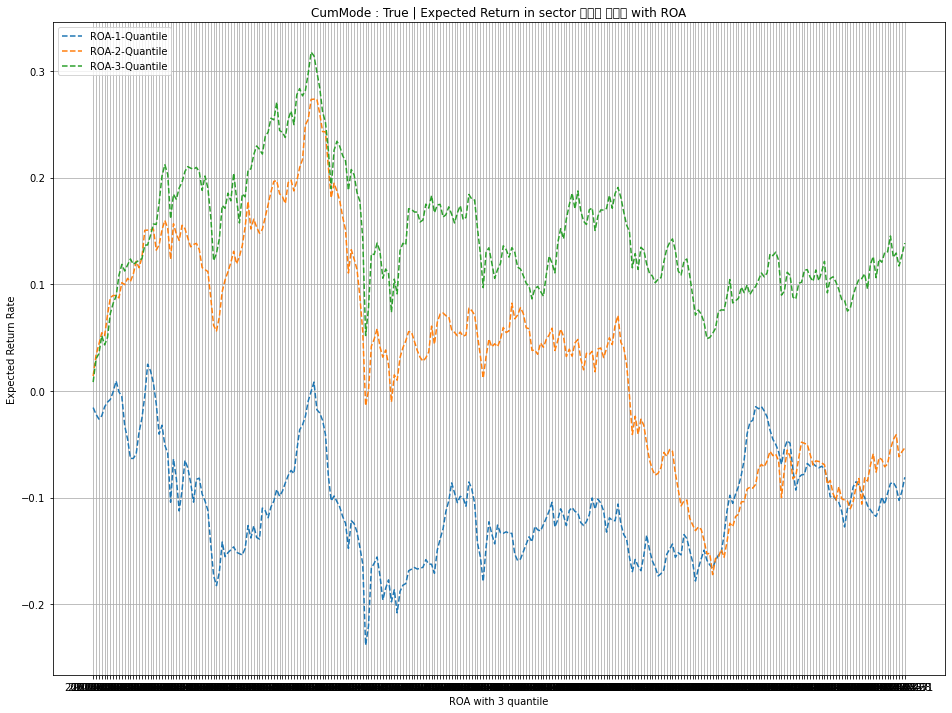

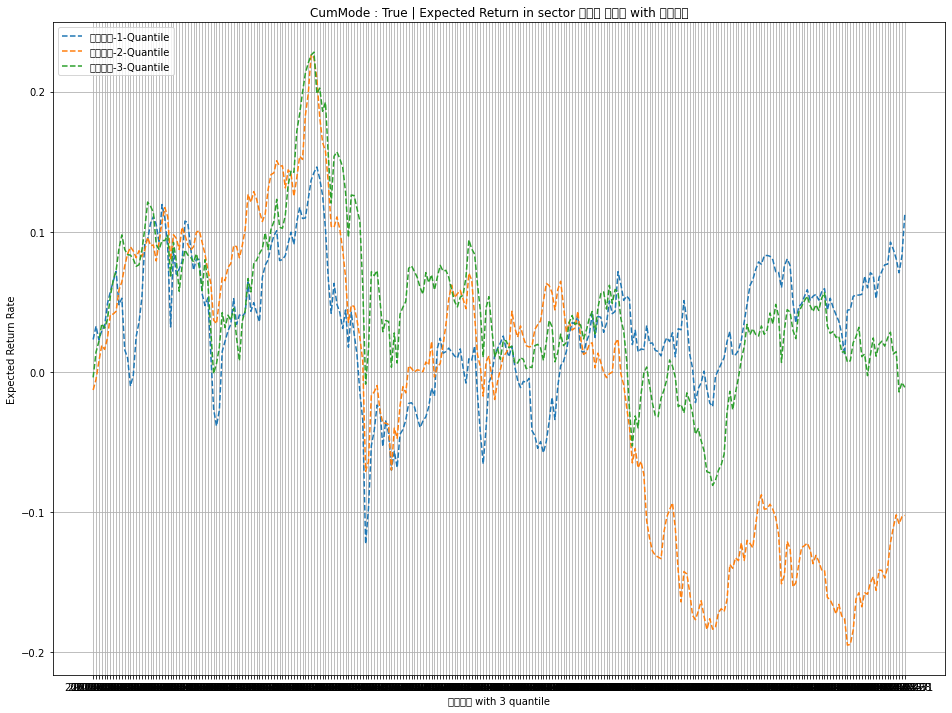

============== Step5 ================
Wall time: 1min 10s


In [136]:
%%time
dt='2012-12'
a1 = PatternChecker(dt, sc='반도체 제조업', doplot=True)

In [148]:
def PatternCheckerAll(sc='반도체 제조업',doplot=False):
    
    dates = [str(y)+'-12' for y in range(2009,2020)]
    all_pr = pd.read_hdf("./FullCache/semiconductor_price.h5")
    conn = pymysql.connect(host='localhost',user='root', password='tlqkfdk2',db='INVESTAR',charset='utf8')
    sc_ls = list(pd.read_sql("select code, sector from company_info", conn)[lambda x : x['sector']==sc].code.values)
    items = ['PBR','PCR','POR','PER','PSR','EPS','BPS','ROE','ROA','시가총액']
    total_summary = pd.DataFrame()
    for dt in dates :
        """Step0 : Default Setting """
        print("============== Step0 ================")
        year = int(dt[:4])
        start = str(year+1)+'-02-03'
        if year != 2019:
            end = str(year+2)+'-01-31'
        else :
            end = '2020-12-31'
        
        pr = all_pr[(all_pr.index>=start)&(all_pr.index<=end)]
        pr.dropna(axis=1, how='all',inplace=True)

        tdf = pd.read_sql(f"select * from finance_info_copy where code in {tuple(sc_ls)} and date='{dt}' and itm in {tuple(items)}",conn)
        fn = SummaryFundaYearly(tdf,dt)

        print("Initial number of comps : {}".format(len(sc_ls)))
        print("Funda-existence Filtered number of comps : {}".format(len(fn)))
        fn_label = Labeling(fn, 3)

        """Step4 : Funda to Best ER """
        #print("============== Step4 ================")
        rst_init_Y, summary_df_dt = AnnualSectorDist_v6(fn_label, pr, dt, sc, cum_mode=True, doplot=doplot)
        total_summary = pd.concat([total_summary, summary_df_dt])

        """Step5 : CoInteg Pairs """
        print("============== Step5 ================")
        #_,_, pairs = Cointegrated_Pairs(pr[list(fn.index)].dropna(axis=1,how='any'),cutoff=0.05) #빼야하나..
    
    return total_summary

In [149]:
%%time
b1 = PatternCheckerAll(sc='반도체 제조업', doplot=False)

============== Step0 ================
Initial number of comps : 57
Funda-existence Filtered number of comps : 21
============== Step5 ================
============== Step0 ================
Initial number of comps : 57
Funda-existence Filtered number of comps : 33
============== Step5 ================
============== Step0 ================
Initial number of comps : 57
Funda-existence Filtered number of comps : 32
============== Step5 ================
============== Step0 ================
Initial number of comps : 57
Funda-existence Filtered number of comps : 36
============== Step5 ================
============== Step0 ================
Initial number of comps : 57
Funda-existence Filtered number of comps : 39
============== Step5 ================
============== Step0 ================
Initial number of comps : 57
Funda-existence Filtered number of comps : 41
============== Step5 ================
============== Step0 ================
Initial number of comps : 57
Funda-existence Filtered nu

In [155]:
b1.shape

(121, 4)

In [159]:
b1.dropna(axis=0,how='all',inplace=True)

In [160]:
b1

,itm,1,2,3
2009-12,PBR,0.327264,0.31713,-0.0139682
2009-12,PCR,0.354864,-0.0322346,0.305438
2009-12,POR,0.56491,0.0485539,0.0175463
2009-12,PSR,0.342546,0.442904,-0.154338
2009-12,PER,0.408491,0.0692512,0.156133
...,...,...,...,...
2019-12,EPS,0.100465,0.196679,0.58704
2019-12,BPS,0.150958,0.297712,0.433826
2019-12,ROE,0.134488,0.226554,0.518985
2019-12,ROA,0.134488,0.226932,0.522545


In [164]:
b1_pbr = b1[lambda x : x['itm']=='PBR']

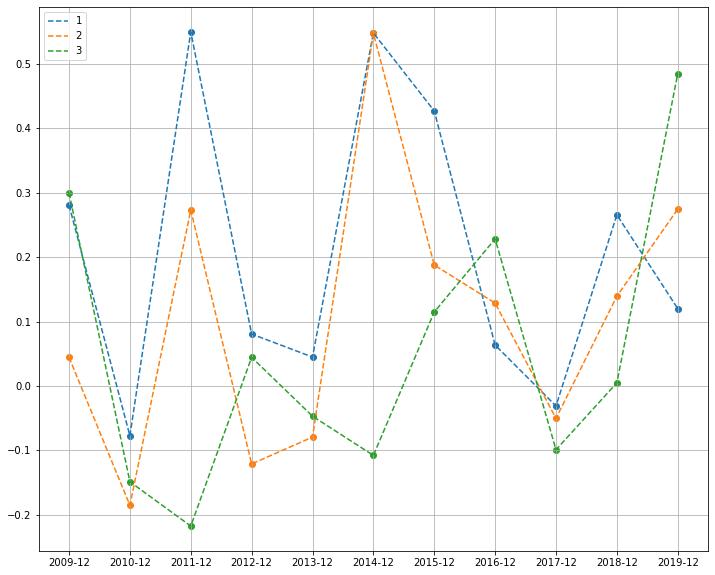

In [197]:
b1_pbr = b1[lambda x : x['itm']=='시가총액']
plt.figure(figsize=(12,10))
plt.plot(b1_pbr.index, b1_pbr['1'],linestyle='--', label='1')
plt.scatter(b1_pbr.index, b1_pbr['1'])
plt.plot(b1_pbr.index, b1_pbr['2'],linestyle='--', label='2')
plt.scatter(b1_pbr.index, b1_pbr['2'])
plt.plot(b1_pbr.index, b1_pbr['3'],linestyle='--', label='3')
plt.scatter(b1_pbr.index, b1_pbr['3'])
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [198]:
b1

,itm,1,2,3
2009-12,PBR,0.327264,0.31713,-0.0139682
2009-12,PCR,0.354864,-0.0322346,0.305438
2009-12,POR,0.56491,0.0485539,0.0175463
2009-12,PSR,0.342546,0.442904,-0.154338
2009-12,PER,0.408491,0.0692512,0.156133
...,...,...,...,...
2019-12,EPS,0.100465,0.196679,0.58704
2019-12,BPS,0.150958,0.297712,0.433826
2019-12,ROE,0.134488,0.226554,0.518985
2019-12,ROA,0.134488,0.226932,0.522545


In [199]:
b11 = b1.copy()

In [226]:
qwe = b11[lambda x : x['itm']=='PBR']

In [237]:
b11_z = b11[['1','2','3']]

In [238]:
b11_z = b11_z.astype(float)

In [241]:
b11_z.iloc[0,:].idxmax()

'1'

In [243]:
b11['1'] = b11['1'].astype(float)
b11['2'] = b11['2'].astype(float)
b11['3'] = b11['3'].astype(float)

In [245]:
ff = []
for i in range(len(b11)):
    ff.append(b11[['1','2','3']].iloc[i,:].idxmax())

In [247]:
b11['Winner'] = ff

In [250]:
b11.to_hdf("./FullCache/semiconductor_pattern.h5",key='pattern')

In [253]:
items = ['PBR','PCR','POR','PER','PSR','EPS','BPS','ROE','ROA','시가총액']
for fd in items :
    print(fd, b11[lambda x : x['itm']==fd]['Winner'].value_counts().index[0])

PBR 1
PCR 1
POR 1
PER 2
PSR 1
EPS 2
BPS 3
ROE 1
ROA 3
시가총액 1


In [257]:
all_pr = pd.read_hdf("./FullCache/semiconductor_price.h5")

In [258]:
all_pr

,000660,000990,004770,011690,011930,017900,020760,032580,033170,033640,...,123860,149010,153490,166090,182690,200710,214310,303030,317120,322000
2010-01-04,24100,7500,949,1400,3370,2875,5266,2085,NaN,14061,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,23350,7550,939,1425,3664,2900,5482,2220,NaN,14717,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,24550,7410,939,1395,3552,2815,5454,2350,NaN,14858,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,24400,7460,967,1375,3858,2750,5313,2200,NaN,14951,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,24650,7510,967,1400,3944,2685,5341,2285,NaN,15233,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,116000,40100,4630,1220,3370,2305,5566,1280,794.0,33650,...,23650.0,5540,1395,26200,2425,28050,1930,2350,10400,37600
2020-12-24,118000,42950,4710,1220,3305,2330,5772,1260,802.0,34800,...,23600.0,5430,1495,26550,2780,28600,1875,2365,10050,37500
2020-12-28,115500,46250,5050,1220,3240,2270,5763,1240,790.0,34800,...,24350.0,5240,1510,26500,2730,28400,1685,2370,9650,37300
2020-12-29,116000,49150,5050,1220,3285,2315,6288,1275,818.0,35000,...,25400.0,4465,1545,27150,2750,28500,1715,2440,9900,39050


In [262]:
Stationarity_Test_Ticker(all_pr[['033170']])

True

In [269]:
""" All Periods"""
print("Initial : ",all_pr.shape[1])
cnt =0
for cd in list(all_pr.columns):
    if Stationarity_Test_Ticker(all_pr[[cd]]):
        cnt += 1
print("All periods : ",cnt)
start_dates = [str(y+1)+'-02-03' for y in range(2009,2020)]
end_dates = [str(y+2)+'-01-31' for y in range(2009,2020)]
for i in range(len(start_dates)):
    cnt=0
    for cd in list(all_pr.columns):
        try :
            zz = all_pr[(all_pr.index>=start_dates[i])&(all_pr.index<=end_dates[i])][[cd]]
            zz = zz.dropna(axis=0)
            if len(zz)<=30:
                continue
            else :
                if Stationarity_Test_Ticker(all_pr[(all_pr.index>=start_dates[i])&(all_pr.index<=end_dates[i])][[cd]]):
                    cnt += 1
        except :
            pass
    print("{}~ periods : {}".format(start_dates[i],cnt))

Initial :  57
All periods :  45
2010-02-03~ periods : 38
2011-02-03~ periods : 42
2012-02-03~ periods : 43
2013-02-03~ periods : 42
2014-02-03~ periods : 48
2015-02-03~ periods : 51
2016-02-03~ periods : 51
2017-02-03~ periods : 47
2018-02-03~ periods : 50
2019-02-03~ periods : 54
2020-02-03~ periods : 52


---

### KOSPI Crawling from Naver Finance

In [71]:
def GetDailyKOSPI_lv1(today='2021-02-25'):
    
    end = today.replace('-','')
    
    url = 'https://m.stock.naver.com/api/json/sise/dailySiseIndexListJson.nhn?code=KOSPI&pageSize=100'
    res = requests.get(url,headers={"User-Agent":"Chrome 88 on Windows 10"})
    rst = res.text
    tmp = res.json()
    kospi = pd.DataFrame(tmp['result']['siseList'])
    kospi['dt'] = kospi['dt'].astype(str)
    
    original = pd.read_hdf("./FullCache/KOSPI.h5")
    print("original size : {}".format(original.shape))
    
    last_date = max(original.dt.values)
    new_kospi = kospi[lambda x : x['dt'] > last_date]
    print("update size : {}".format(new_kospi.shape))
    
    original = pd.concat([new_kospi,original])
    print("merged size : {}".format(original.shape))
    
    original.to_hdf("./FullCache/KOSPI.h5",key='kospi')
    new_kospi.to_hdf("./FullCache/KOSPI_update_{}.h5".format(end),key='kospi')
    
    return True

In [73]:
GetDailyKOSPI_lv1('2021-02-26')

original size : (8100, 8)
update size : (10, 8)
merged size : (8110, 8)


True

In [95]:
def GetDailyKOSPI_lv2(today='2021-02-25'):
    
    if os.path.isfile(glob.glob("./FullCache/KOSPI_update_*.h5")[0]):
        pass
    else :
        raise ValueError("lv1 update file does not exist!!!")
        
    tmp = pd.read_hdf(glob.glob("./FullCache/KOSPI_update_*.h5")[0])
    total = pd.read_hdf("./FullCache/KOSPI_lv2.h5")
    print('total size : {}'.format(total.shape))
    
    dates = [dt[:4]+'-'+dt[4:6]+'-'+dt[6:8] for dt in list(tmp.dt.values)]
    tmp.index = dates
    tmp = tmp[['ncv']].sort_index()
    tmp.columns = ['close']
    print("update size : {}".format(tmp.shape))
    assert len(tmp)!=0
    total = pd.concat([total,tmp]).sort_index()
    print("merged size : {}".format(total.shape))
    total.to_hdf("./FullCache/KOSPI_lv2.h5",key='kospi')
    print("Daily lv2 KOSPI update is finished -> {} ~ {}".format(min(tmp.index), max(tmp.index)))
    
    os.remove(glob.glob("./FullCache/KOSPI_update_*.h5")[0])
    return True

In [96]:
GetDailyKOSPI_lv2('2021-02-26')

total size : (8100, 1)
update size : (10, 1)
merged size : (8110, 1)
Daily lv2 KOSPI update is finished -> 2021-02-15 ~ 2021-02-26


True

---

In [2]:
url = 'https://m.stock.naver.com/api/json/sise/dailySiseIndexListJson.nhn?code=KOSPI&pageSize=10000&page=1'

In [41]:
url = 'https://m.stock.naver.com/api/json/sise/dailySiseIndexListJson.nhn?code=KOSPI&pageSize=100000'

In [ ]:
res = requests.get(url)

In [25]:
rst = res.text

In [26]:
tmp = res.json()

In [13]:
tmp['result']['siseList'][0]

{'cd': 'KOSPI',
 'dt': '20210225',
 'ncv': 3090.53,
 'cv': 95.55,
 'cr': 3.19,
 'ov': 3026.47,
 'hv': 3090.53,
 'lv': 3026.47}

In [14]:
kospi = pd.DataFrame(tmp['result']['siseList'])

In [43]:
new = kospi.sort_values(by=['dt'],ascending=False).head(10)

In [47]:
dates = list(new.sort_values(by=['dt']).dt.values)
dates = [e[:4]+'-'+e[4:6]+'-'+e[6:] for e in dates]

In [49]:
dates.pop(-1)

'2021-02-25'

In [51]:
new = new[lambda x : x['dt']<='20210224']

In [56]:
new = new[['dt','ncv']].sort_values(by=['dt'])

In [57]:
new

,dt,ncv
9,20210210,3100.58
8,20210215,3147.00
7,20210216,3163.25
6,20210217,3133.73
5,20210218,3086.66
4,20210219,3107.62
3,20210222,3079.75
2,20210223,3070.09
1,20210224,2994.98


In [59]:
new.index = dates

In [61]:
new.drop(['dt'],axis=1,inplace=True)

In [63]:
new.columns = ['close']

In [68]:
new.drop('2021-02-10',axis=0,inplace=True)

In [17]:
ksp = pd.read_hdf("./FullCache/KOSPI_close.h5")

In [19]:
ksp.tail()

,close
2021-02-04,3087.55
2021-02-05,3120.63
2021-02-08,3091.24
2021-02-09,3084.67
2021-02-10,3100.58


In [70]:
total = pd.concat([ksp,new])

In [72]:
total.to_hdf("./FullCache/KOSPI_clos.h5",key='kospi')

In [29]:
kospi.to_csv("./FullCache/KOSPI.csv",index=False)

In [30]:
pd.read_csv("./FullCache/KOSPI.csv")

,cd,dt,ncv,cv,cr,ov,hv,lv
0,KOSPI,20210210,3100.58,15.91,0.52,3088.13,3111.88,3064.25
1,KOSPI,20210209,3084.67,-6.57,-0.21,3102.25,3129.66,3084.67
2,KOSPI,20210208,3091.24,-29.39,-0.94,3113.63,3128.54,3085.59
3,KOSPI,20210205,3120.63,33.08,1.07,3098.49,3124.62,3081.78
4,KOSPI,20210204,3087.55,-42.13,-1.35,3135.02,3135.02,3068.46
...,...,...,...,...,...,...,...,...
8095,KOSPI,19900109,920.21,0.75,0.08,923.82,923.82,914.64
8096,KOSPI,19900108,919.46,6.60,0.72,916.33,920.48,909.22
8097,KOSPI,19900106,912.86,-2.25,-0.25,915.13,921.51,912.86
8098,KOSPI,19900105,915.11,-13.71,-1.48,926.56,931.56,913.66
